## Analysis code for 'Are colour experiences the same across the visual field?'
### Pre-registration code
Written by Ariel Zeleznikow-Johnston, 2021
ariel.zeleznikow-johnston@monash.edu  
Github link to experiment: https://github.com/ArielZJ/SimilarityColorProject-MultiplePatches  
Github link to this analysis code: https://github.com/ArielZJ/Precision-Phenomenology-Data-Analysis

### Initialisations

In [1]:
filename = "data/pilotcompiled.csv"
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later

In [2]:
# various parameters
stimuli_number = 9
response_type_list = c('during')
trial_types = c('during')
response_names = c('During')
catch_trial_number = 10 # what it's set at at the moment, arbitrary
condition_number = 3
max.DSR = 7
min.DSR = 0

In [65]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 0 # mean reaction times must be above this
score_cutoff=0.77

In [4]:
exclude_noncompliant = FALSE

In [5]:
# colors for the labels
# changed for this mixed version
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9',"#00A9FF",'#0000FF','#AA00FF',"#FF00AA")
abcolors <- sort(colors)

eccens.colors <- c(
    'Central #FF0000',
    'Central #FFAA00',
    'Central #AAFF00',
    'Central #00FF00',
    'Central #00FFA9',
    "Central #00A9FF",
    'Central #0000FF',
    'Central #AA00FF',
    "Central #FF00AA",
    'Peripheral #FF0000',
    'Peripheral #FFAA00',
    'Peripheral #AAFF00',
    'Peripheral #00FF00',
    'Peripheral #00FFA9',
    "Peripheral #00A9FF",
    'Peripheral #0000FF',
    'Peripheral #AA00FF',
    "Peripheral #FF00AA")

inverted.colors <-  c('#FF0000','#FF00AA','#AA00FF','#0000FF','#00A9FF','#00FFA9','#00FF00','#AAFF00','#FFAA00')

### Initialisations

In [6]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [7]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)
#library(fclust)
library(plot.matrix)
#library(gtools)
library(stringi)
#library(Bolstad)
library(olsrr) # for checking violation of regression assumptions
library(lmtest) # for likelihood ratio test
library(car) # for logistic transformation
library(betareg) # beta regressions
library(coin) # wilcox power analyses
library(rstatix) # power analyses
library(boot)
library(cowplot) # for making figures
library(readr) # for making figures


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-7

Attaching package: 'olsrr'

The following object is masked from 'package:MASS':

    cement

The following object is masked from 'package:datasets':

    rivers

Loading re

In [8]:
# getting bayesbr to do the bayesian analysis
library(bayesbr)
library(BayesFactor)
#library(brms)
library(rstanarm)
library(bridgesampling)
library(bayestestR)
#library(see)
#library(bayesplot)


Attaching package: 'bayesbr'

The following object is masked from 'package:boot':

    envelope

Loading required package: coda
************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Attaching package: 'BayesFactor'

The following object is masked from 'package:betareg':

    posterior

Loading required package: Rcpp
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 
This is rstanarm version 2.21.1
- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!
- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.
- For execution on a local, multicore CPU with excess RAM we recommend calling
  options(mc.cores = para

In [9]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [10]:
# check our N 
get_n <- function(datadf){
    n <- length(unique(datadf$subject))
    print(paste("There are",n,"unique subjects"))
    return(n)
}

In [11]:
get_n.grouped <- function(datadf){
    size <- sort(unique(datadf$stimulus_radius))
    scale <- sort(unique(datadf$peripheral_scale))
    for(stim in (size)){
        for(mag in (scale)){
            data <- (subset(datadf,stimulus_radius == stim & peripheral_scale == mag))
            n <- length(unique(data$subject))
            print(paste('Magnification',mag,'Size',stim,' - N =',n))
        }
    }
}

In [12]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Central'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Central'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Central')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Central'){
        return(-1)
    } else {
        return(1)
    }
}

In [13]:
get.submat <- function(mat,submat){
    if(submat == 'CC'){
        out.mat <- mat[1:9,1:9]
    } else if (submat == 'CP'){
        out.mat <- mat[1:9,10:18]
    } else if (submat == 'PP'){
        out.mat <- mat[10:18,10:18]
    }
    return(out.mat)
}

#### Dissimilarity Matrices

In [14]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
# doesn't care whether this comes from individual subjects or whole populations
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [15]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = similarity)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [16]:
# making a matrix symmetric. Borrowed from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not a square matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

In [17]:
# obtain dissimilarity dataframe that corresponds to all of a subject's judgements
# adds the columns color1.eccen1 and color2.eccen2
dissimdata.subject <- function(datadf, diagnose=FALSE){
        
    # first, get a full label for each trial
    datadf <- subset(datadf, trial_type != 'catch') # get rid of catch trials
    
    datadf$Circle_1[datadf$Circle_1 == -1] <- 'Central'
    datadf$Circle_2[datadf$Circle_2 == -1] <- 'Central'
    datadf$Circle_1[datadf$Circle_1 == 1] <- 'Peripheral'
    datadf$Circle_2[datadf$Circle_2 == 1] <- 'Peripheral'
    datadf$color1.eccen1 <- paste(datadf$Circle_1,datadf$Color_1,sep=' ')
    datadf$color2.eccen2 <- paste(datadf$Circle_2,datadf$Color_2,sep=' ')
    datadf$color1 <- datadf$Color_1
    datadf$color2 <- datadf$Color_2

    
    # refactor the levels so they can be plotted properly later if need be
       datadf$color1.eccen1 <- with(datadf, factor(color1.eccen1, levels = eccens.colors))
       datadf$color2.eccen2 <- with(datadf, factor(color2.eccen2, levels = eccens.colors))
    if(diagnose){print(paste("Subject trial number:", nrow(datadf)))}
     
    
    #print(datadf$color1.eccen1)
    return(datadf)
}

In [129]:
# convert a df to a group of subject matrices
dissimgroup2matlist <- function(df,sym=TRUE){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    mat.list <- list()
    k = 1
    for(ID in subjectlist){
        subjectdf <- subset(df, subject == ID)
        subject.mat <- color.eccen.mat(dissimdata.subject(subjectdf), output='matrix',
                                       symmeterise=sym,sym.CP=sym)
        mat.list[[k]] <- subject.mat
        k = k + 1
    }
    return(mat.list)
} 

In [19]:
# convert a group of matrices to a group mean matrix
group.mat.mean <- function(mat.list){
    # average the matrices
    mat.average <- Reduce('+',mat.list)/length(mat.list)
    return(mat.average)
}
   

In [20]:
# convert a group of matrices to a group median matrix
group.mat.median <- function(mat.list){
    
    out.v <- vector()
    
    n.vals <-length(c(mat.list[[1]]))
    n.subjects <- length(mat.list)
    for(i in 1:n.vals){
        vals <- vector()
        for(j in 1:n.subjects){
            v <- c(mat.list[[j]])[i]
            vals <- c(vals,v)
        }
        out.v[i] <- median(vals)
    }
    
    out.mat <- matrix(out.v,nrow(mat.list[[1]]),ncol(mat.list[[1]]))
    
    colnames(out.mat) <- colnames(mat.list[[1]])
    rownames(out.mat) <- rownames(mat.list[[1]])
    
    return(out.mat)
}

In [21]:
# convert a full matrix to a variance matrix
full2var <- function(mat){
    # initialise the output variance matrix
    var.mat <- matrix(,nrow(mat)/2,ncol(mat)/2)
    
    # fill the output variance matrix
    for(row in 1:(nrow(mat)/2)){
        for(column in 1:(ncol(mat)/2)){

            CC <- mat[row,column]
            CP <- mat[row + nrow(var.mat), column]
            PP <- mat[row + nrow(var.mat), column + nrow(var.mat)]
            
            val <- var(c(CC,CP,PP))
            var.mat[row,column] <- val
        }
    }
    colnames(var.mat) <- colors
    rownames(var.mat) <- colors
    # return
    return(var.mat)
}

In [22]:
# convert a group of full color matrices to a group of within-subject mean color-pair variance matrices
full2var.mats <- function(mat.list){
    var.list <- list()
    for(mat in 1:length(mat.list)){
        var.list[[mat]] <- full2var(mat.list[[mat]])
    }
    return(var.list)
}

In [23]:
# make a dissimilarity plot for a group of subjects
group.dissim <- function(df,sym=FALSE){
    mats <- dissimgroup2matlist(df,sym=sym)
    avg.mat <- group.mat.mean(mats)
    
    data <- melt(avg.mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','similarity')
    return(data)
    
    
}




In [24]:
# make a median variance plot for a group of subjects
group.dissim.var <- function(df){
    mats <- dissimgroup2matlist(df)
    mats.var <- full2var.mats(mats)
    avg.mat <- group.mat.median(mats.var)
    
    data <- melt(avg.mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','similarity')
    return(data)
    
    
}


In [123]:
# label the rows with the two colours independent of arbitrary ordering
dissimplot.full <- function(datadf, mode='standard',
                            rotation=90,dependent='dissimilarity',
                           reverse=TRUE,
                           label='',info='TRUE'){
        
    if(dependent=='RT'){
        #datadf$similarity <- log10(datadf$similarity)
    }
    
    plot <- ggplot(datadf, aes(x = color1.eccen1, y = color2.eccen2)) 
    
    if(mode=='standard'){
        color.list <- c(colors,colors)
    } else if (mode=='inversion'){
        color.list <- c(colors, inverted.colors)
    } else if (mode == 'rotation'){
        color.list <- c(colors, rotate.vec(colors,rotation))
    }
    
    
    
    # dissimilarity plot
    if(dependent=='dissimilarity'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"),
                                    limits=c(0,7),
                                    breaks=c(0,1,2,3,4,5,6,7),
                                    na.value='darkblue') +
                guides(fill=guide_legend(title="Dissimilarity"))
    }
    # reaction time plot
    if(dependent=='RT'){
        plot <- plot + geom_raster(aes(fill = similarity)) +
                scale_fill_gradientn(colours = c("white","black"), trans = "log",
                                    #limits=c(1000,1600),
                                    #limits=c(2.9,3.3),
                                    #breaks=c(2.9,3,3.146,3.255,3.3),
                                     limits = c(800,2000),
                                    breaks=c(800,1000,1400,1800),
                                    labels=c(800,1000,1400,1800)
                                    ) +
                guides(fill=guide_legend(title="RT (log)"))
    }
    # reverse plot
    if(reverse){
        plot <- plot + scale_y_discrete(limits = rev(levels(datadf$y)))
    }
    
    if(info){ # labels on
        plot <- plot + theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                    ggtitle(label)
    } else {  # labels off
        plot <- plot + theme(axis.text.x = element_blank(),
                        axis.text.y = element_blank(),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_blank(), legend.position='none')
    } 
    
    return(plot)
    
}

In [26]:
# convert a dataframe to a matrix. Only works on submatrices
df2mat.full <- function(datadf,eccentricity1=l2e('Central'),eccentricity2=l2e('Central'),sym=FALSE){
 
    # select only the eccentricities we want to keep, e.g. (Central, Central)
    datadf <- subset(datadf, Circle_1 == eccentricity1 & Circle_2 == eccentricity2)

    # aggregate over the remaining columns of interest
    datadf <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    datadf$Color_1 <- datadf$Group.1
    datadf$Color_2 <- datadf$Group.2

    datadf = subset(datadf, select = c("Color_1","Color_2","similarity"))  # get rid of unnecessary columns
    datadf <- spread(datadf, Color_1, similarity)
    
    # convert the dataframe to a matrix
    datamatrix <- data.matrix(datadf)
    datamatrix <- datamatrix[,-1] # get rid of the labels in the first column, it messes up the code
    if(sym){
        datamatrix <- make.symmetric(datamatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    }
    rownames(datamatrix) <- colnames(datamatrix)
    
    # sort the matrix
    datamatrix <- datamatrix[, sort(colnames(datamatrix))][sort(rownames(datamatrix)),]
    
    return(datamatrix)
    
}

In [27]:
# variance plot for matrices
variance.plot <- function(mat,
                         col1='blue',col2='yellow',na.col='green',
                                  legend.title='Variance',
                                  xlabel='',ylabel='',
                                  low.lim=0,up.lim=10){
    if(ncol(mat)<10){
        color.list <- colors
    } else {
        color.list <- c(colors,colors)
    }
    longData <- melt(mat)
    
    
    plot <- ggplot(longData, aes(x = Var2, y=Var1)) + 
    geom_raster(aes(fill=value)) +
    scale_fill_gradientn(legend.title,colours = c(col1,col2),
                         limits = c(low.lim,up.lim), 
                         breaks=c(low.lim,up.lim),
                        na.value=na.col) + 
    theme(axis.text.x = element_text(colour=color.list,angle=90),
                        axis.text.y = element_text(colour=color.list),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))

    return(plot)
}
    

In [28]:
# convert a dataframe to a matrix v2, with some added functionality and without automatic
# symmeterisation
color.eccen.mat <- function(df,output='DF',mode='identity',rotation=90,plot=FALSE,dependent='dissimilarity',
                           symmeterise=TRUE,sym.CP=TRUE,
                            diagnose=FALSE){
    library('plot.matrix')
    if(dependent=='RT'){
        df$similarity <- df$response_time
    }
    data <- subset(df, select = c(color1.eccen1, color2.eccen2, similarity))
    if(diagnose){
        print(data)
    }
    #print(head(data)) # testing
    data <- spread(data, color1.eccen1, similarity)
    #print(data) # testing
    row.names <- data$color2.eccen2
    data.mat <- data.matrix(data)
    rownames(data.mat) <- row.names
    data.mat <- data.mat[,-1] # get rid of the redundant first column
    
    # duplicate missing values
    #print(plot(data.mat))
    if(symmeterise){
        if(sym.CP){ # symmeterise over CP/PC
            CP <- data.mat[10:18,1:9]
            CP.t <- t(CP)
            data.mat[10:18,1:9] <- group.mat.mean(list(CP,CP.t))
            data.mat[1:9,10:18] <- t(data.mat[10:18,1:9])
        }
        # symmeterise the full matrix
        data.mat.t <- t(data.mat)
        data.mat <- group.mat.mean(list(data.mat,data.mat.t))
    }
    # perform a label swap
    peripheral.labels <- c(10:18)
    if(mode == 'random'){
        swap.vec <- sample(peripheral.labels) # pick a random ordering of the peripheral labels
    } else if (mode == 'rotate'){
        swap.vec <- rotate.vec(peripheral.labels,rotation=rotation)
    } else if (mode == 'invert'){
        swap.vec <- match(inverted.colors,colors) + 9
    }
    if(mode != 'identity'){ # do the swap
        data.mat[10:18,] <- data.mat[swap.vec, ] # reorder the rows
        data.mat[,10:18] <- data.mat[, swap.vec] # reorder the columns
    }
        
    
    # plot the data
    if(plot){
        plot(data.mat, col=gray.colors(8, start=0, end=1, gamma=0.75, rev=TRUE),
         xlab = 'Fovea                                      Periphery',
        ylab = 'Fovea                                      Periphery')
    }
    
    # choose output type
    if(output == 'DF'){
        data <- as.data.frame(as.table(data.mat))
        colnames(data) <- c("color1.eccen1","color2.eccen2","similarity")
        return(data)
    } else if (output == 'matrix'){
        return(data.mat)
    }
}

In [133]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Central'))
    fpmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Peripheral'))
    pmatrix <- df2mat.full(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    cc <- sum(diag(fmatrix))/nrow(fmatrix)
    cp <- sum(diag(fpmatrix))/nrow(fpmatrix)
    pp <- sum(diag(pmatrix))/nrow(pmatrix)
    
    
    return(list(cc,cp,pp))
}

norm.trace.cc <- function(datadf){
    fmatrix <- df2mat.full(datadf, l2e('Central'), l2e('Central'))
    cc <- sum(diag(fmatrix))/nrow(fmatrix)
    return(cc)
}

In [30]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),
                          fftrace=double(),
                          fptrace=double(),
                          pptrace=double(),
                         stim_size=double(),
                         magnification=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        subject_trace <- trace_avg(tempdf)
        stim <- unique(tempdf$stimulus_radius)[1]
        mag <- unique(tempdf$peripheral_scale)[1]
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),
                             as.numeric(subject_trace[2]),
                             as.numeric(subject_trace[3]),
                            stim,mag)
        names(row_df) <- c("subject","CC",'CP',"PP",'StimSize','Magnification')
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [31]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [32]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [33]:
# calculate the catch trial score for a subject
catch_score <- function(datadf){
    datadf <- subset(datadf, trial_type == 'catch')
    datadf$correct <- ifelse(as.character(datadf$similarity) == as.character(datadf$catch_vals), 1, 0) # determine whether they got the catch trials right
    score <- sum(datadf$correct)/nrow(datadf) # get the score
    return(score)
}

In [34]:
# catch trial checker
catch_trial_checker <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Catch scores")
    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid)
        
        catch_trials <- subset(subjectdf, trial_type == 'catch')
        catch_num = nrow(catch_trials)
        catch_correct = nrow(subset(catch_trials, as.character(catch_vals) == as.character(similarity))) # had to add the as.character to block a bug, don't know why
        
        print(paste("Subject",subjectid,":",catch_correct,"/",catch_num))
    }
}

In [35]:
# screen parameters
screen_parameters <- function(datadf,individual=FALSE){
    
    subjectlist <- sort(unique(datadf$subject))
    print("Screen Parameters")
    screen_fail = 0
    viewing_fail = 0
    for (subjectid in subjectlist){

        subjectdf = subset(datadf, subject == subjectid)
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        
        if(screen_size < 20){screen_fail = screen_fail + 1}
        if(viewing_distance < 30){viewing_fail = viewing_fail + 1}
        
        if(individual){
            print(paste("Subject",subjectid,":"))
            print(paste("Screen size:",screen_size,"cm"))
            print(paste("Viewing distance:",viewing_distance,"cm"))
            print("")
        }
        
        
    }
    print("")
    print(paste("Screen size issues:",screen_fail,"/",length(subjectlist)))
    print(paste("Viewing distance issues:",viewing_fail,"/",length(subjectlist)))
}

#### Multidimensional Scaling Plots

In [36]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Classical multidimensional scaling

In [37]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [38]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [39]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = similarity)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf,QDM='FULL'){
    
    if(QDM == 'FP'){
        datadf <- subset(datadf, ((Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral')) |
                                 (Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Central'))
                                 ))
    }
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = similarity)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = paste(QDM,'Dissimilarity')) +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [40]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time)) + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    plot <- ggplot(datadf, aes(x= similarity, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    stat_summary(fun.y = mean, geom = "line", size=2.5, aes(group=1)) + # add a population summary
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [41]:
# mean reaction time vs. catch trial score
rt_catch <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$catch_score[datadf$subject == ID] = unlist(catch_score(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_catch_plot <- function(datadf,xtype='linear',label=FALSE){
    
    datadf <- rt_catch(datadf)
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x=response_time, y=catch_score)) +
            geom_point() + xlab("Median Reaction Time") + ylab("Catch Score")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')+ xlim(0,5000)
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) + ylim(0,1) + # linear line of best fit
            geom_hline(yintercept=score_cutoff, linetype = 'dashed', color='red') 
            #geom_vline(xintercept=rt_cutoff, linetype = 'dashed', color='blue')
    #plot <- plot + geom_point(aes(color = subject))
    if(label){
        plot <- plot + geom_text(aes(label = subject),check_overlap=TRUE)
    }
    return(plot)
}

rt_hist <- function(datadf){
    datadf <- rt_catch(datadf)
    mu <- (median(datadf$catch_score))
    sd <- (sd(datadf$catch_score))
    print(paste("Median +/- 1 SD:",round(mu,2),'+/-',round(mu-sd,2),'to',round(mu+sd,2)))
    print(paste("Median +/- 2 SD:",round(mu,2),'+/-',round(mu-sd*2,2),'to',round(mu+sd*2,2)))
    plot <- ggplot(datadf, aes(x = catch_score)) + 
            geom_histogram(binwidth=0.1,colour='black') + xlim(-0.05,1.05) + xlab('Catch Score')
    return(plot)
}

In [42]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

#### Check their screen size & viewing distance

In [43]:
# screen size in mm
screen_size <- function(datadf){
    
    datadf <- subset(datadf, trialcode == 'centermouse') # make sure calibrations have finished first
    
    width <- as.numeric(substr(as.character(datadf$screen_size_x)[1],1,6))
    height <- as.numeric(substr(as.character(datadf$screen_size_y)[1],1,6))
    
    # use pythagoras to just get the hypotenuse. Subjects have a fixed 16/9 aspect ratio so these are all comparable
    return(sqrt(width*width + height*height))
}

In [44]:
# viewing distance in mm
view_distance <- function(datadf){
    return(as.numeric(substr(as.character(datadf$viewer_distance)[1],1,6)))
}

In [45]:
# get a list of subject matrices based on conditions
subject.mats <- function(df,scaling,radius){
    subset.df <- subset(df, peripheral_scale == scaling & stimulus_radius == radius)
    group.mats <- dissimgroup2matlist(subset.df)
    return(group.mats)
}

## Preprocessing

#### Loading the data

In [46]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


#### Cleaning the data as per the exclusion criteria

In [47]:
# CLEAN THIS UP
#weird bug in a subject data for arielzj_fvp_2stim_fixed_point25dva_v2_20_08_30 (1)
datadf <- subset(datadf, (subject != 660294531) & (subject != 21721408) & (subject != 238973028))

In [48]:
# remove practice trial data
datadf <- subset(datadf, blockcode == 'experiment')

In [49]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))



In [50]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
Central = -1
peripheral = 1

In [51]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(eccen_type = case_when(Circle_1 == l2e('Central') & Circle_2 == l2e('Central') ~ 'CC',
                             Circle_1 == l2e('Central') & Circle_2 == l2e('Peripheral') ~ 'CP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'CP'))
    return(datadf)
}

In [52]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [53]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    print(paste(length(subjectlist),"in dataset"))
    print("")
    
    for (ID in subjectlist){ # go through subject by subject
        
        trialnumber = stimuli_number*stimuli_number*condition_number + catch_trial_number
        
        trialsdone <- nrow(subset(datadf, subject == ID))
        print(paste("Subject",ID,"completed",trialsdone,"/",trialnumber))
        
        if ( trialsdone != trialnumber){ # see if they have the appropriate trial numbers
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [54]:
screen_parameters(datadf)

[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 191"
[1] "Viewing distance issues: 0 / 191"


In [55]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "191 in dataset"
[1] ""
[1] "Subject 3248455 completed 253 / 253"
[1] "Subject 9522584 completed 253 / 253"
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 13228849 completed 253 / 253"
[1] "Subject 35587329 completed 253 / 253"
[1] "Subject 35716339 completed 253 / 253"
[1] "Subject 40354804 completed 253 / 253"
[1] "Subject 41471776 completed 32 / 253"
[1] "Subject 48341337 completed 253 / 253"
[1] "Subject 50823202 completed 253 / 253"
[1] "Subject 51805023 completed 253 / 253"
[1] "Subject 53858324 completed 253 / 253"
[1] "Subject 63991259 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 74258126 completed 12 / 253"
[1] "Subject 75394365 completed 253 / 253"
[1] "Subject 80499026 completed 253 / 253"
[1] "Subject 81903961 completed 253 / 253"
[1] "Subject 95990930 completed 2 / 253"
[1] "Subject 98665966 completed 253 / 253"
[1] "Subject 99640956 completed 253 / 253"
[1] "Subject 107179842 completed 37 / 253"
[1] "Subject 120361401 completed

In [56]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,
                               screen_size_cutoff=26,viewing_distance_cutoff=30,rt_threshold=rt_cutoff,score_cutoff=0.7){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        
        screen_size <- round(screen_size(subjectdf)/10,1)
        viewing_distance <- round(view_distance(subjectdf)/10,1)
        catch_score <- catch_score(subjectdf)
        
        if(catch_score > score_cutoff){ # catch score cutoff
            if(screen_size > screen_size_cutoff){ # screen size cutoff
                if(viewing_distance > viewing_distance_cutoff){ # viewing distance cutoff
                    if(rt_avg(subjectdf) > rt_threshold){ # rt cutoff
                        datadf$noncompliant[datadf$subject == ID] = 0
                    } else {
                        print(paste("Subject",ID,"reaction time of:",rt_avg(subjectdf),"ms",sep=' ')) # RT fail
                        datadf$noncompliant[datadf$subject == ID] = 1
                    }
                } else {
                    print(paste("Subject",ID,"viewing distance of:",viewing_distance,"cm",sep=' ')) # Viewing distance fail
                    datadf$noncompliant[datadf$subject == ID] = 2
                }
            } else {
                print(paste("Subject",ID,"had a screen size of:",screen_size,"cm",sep=' ')) # Screen size fail
                datadf$noncompliant[datadf$subject == ID] = 3
            } 
      } else {
            print(paste("Subject",ID,"had a catch score of: ",catch_score,sep=' ')) # Catch score faile
            datadf$noncompliant[datadf$subject == ID] = 4
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [57]:
catch_trial_checker(datadf)

[1] "Catch scores"
[1] "Subject 3248455 : 10 / 10"
[1] "Subject 9522584 : 6 / 10"
[1] "Subject 11005010 : 10 / 10"
[1] "Subject 13228849 : 9 / 10"
[1] "Subject 35587329 : 10 / 10"
[1] "Subject 35716339 : 10 / 10"
[1] "Subject 40354804 : 10 / 10"
[1] "Subject 48341337 : 10 / 10"
[1] "Subject 50823202 : 10 / 10"
[1] "Subject 51805023 : 10 / 10"
[1] "Subject 53858324 : 9 / 10"
[1] "Subject 63991259 : 10 / 10"
[1] "Subject 64413254 : 10 / 10"
[1] "Subject 75394365 : 10 / 10"
[1] "Subject 80499026 : 10 / 10"
[1] "Subject 81903961 : 6 / 10"
[1] "Subject 98665966 : 10 / 10"
[1] "Subject 99640956 : 10 / 10"
[1] "Subject 120361401 : 1 / 10"
[1] "Subject 133207874 : 7 / 10"
[1] "Subject 147071530 : 7 / 10"
[1] "Subject 165762185 : 10 / 10"
[1] "Subject 170537732 : 10 / 10"
[1] "Subject 172093576 : 7 / 10"
[1] "Subject 176476116 : 10 / 10"
[1] "Subject 176698125 : 10 / 10"
[1] "Subject 204525930 : 10 / 10"
[1] "Subject 211745977 : 10 / 10"
[1] "Subject 219326440 : 7 / 10"
[1] "Subject 225280441 :

In [58]:
datadf <- label_noncompliant(datadf)

[1] "Subject 9522584 had a catch score of:  0.6"
[1] "Subject 81903961 had a catch score of:  0.6"
[1] "Subject 120361401 had a catch score of:  0.1"
[1] "Subject 133207874 had a catch score of:  0.7"
[1] "Subject 147071530 had a catch score of:  0.7"
[1] "Subject 172093576 had a catch score of:  0.7"
[1] "Subject 219326440 had a catch score of:  0.7"
[1] "Subject 244316230 had a catch score of:  0.5"
[1] "Subject 252347716 had a catch score of:  0.6"
[1] "Subject 254207207 had a catch score of:  0.4"
[1] "Subject 265310712 had a catch score of:  0.1"
[1] "Subject 285550479 had a catch score of:  0.1"
[1] "Subject 307922435 had a catch score of:  0.4"
[1] "Subject 369400829 had a catch score of:  0.7"
[1] "Subject 382104984 had a catch score of:  0"
[1] "Subject 429304075 had a catch score of:  0.4"
[1] "Subject 463372698 had a catch score of:  0.7"
[1] "Subject 471457102 had a catch score of:  0.3"
[1] "Subject 475089391 had a catch score of:  0.7"
[1] "Subject 517476929 had a catch s

In [59]:
# function to run all these checks at once
validation <- function(datadf){
    
    magnification_list <- sort(unique(datadf$peripheral_scale))
    size_list <- sort(unique(datadf$stimulus_radius))
    
    for (stimulus in size_list){
        for (scale in magnification_list){
            tempdf <- subset(datadf, peripheral_scale == scale & stimulus_radius == stimulus)
            
            print(paste("Magnification",scale,"Stimulus",stimulus))
            tempdf <- remove_incomplete(tempdf,stimuli_number)
            screen_parameters(tempdf, individual=FALSE)
            catch_trial_checker(tempdf)
            label_noncompliant(tempdf)
            print("")
            print("____________________")
            print("")
            
        }
    }
}

In [60]:
validation(datadf)

[1] "Magnification 1 Stimulus 0.05"
[1] "18 in dataset"
[1] ""
[1] "Subject 11005010 completed 253 / 253"
[1] "Subject 64413254 completed 253 / 253"
[1] "Subject 294207097 completed 253 / 253"
[1] "Subject 338738516 completed 253 / 253"
[1] "Subject 340691821 completed 253 / 253"
[1] "Subject 343319516 completed 253 / 253"
[1] "Subject 373678849 completed 253 / 253"
[1] "Subject 376591610 completed 253 / 253"
[1] "Subject 507377004 completed 253 / 253"
[1] "Subject 603387860 completed 253 / 253"
[1] "Subject 626450633 completed 253 / 253"
[1] "Subject 682309552 completed 253 / 253"
[1] "Subject 689093004 completed 253 / 253"
[1] "Subject 754276419 completed 253 / 253"
[1] "Subject 821695709 completed 253 / 253"
[1] "Subject 902494953 completed 253 / 253"
[1] "Subject 909015666 completed 253 / 253"
[1] "Subject 960528676 completed 253 / 253"
[1] "Screen Parameters"
[1] ""
[1] "Screen size issues: 0 / 18"
[1] "Viewing distance issues: 0 / 18"
[1] "Catch scores"
[1] "Subject 11005010 : 10

In [61]:
cleandf <- subset(datadf, noncompliant == 0)
get_n(cleandf)

[1] "There are 144 unique subjects"


[1] 144

## Descriptive Statistics

[1] "Median +/- 1 SD: 1 +/- 0.77 to 1.23"
[1] "Median +/- 2 SD: 1 +/- 0.54 to 1.46"


`geom_smooth()` using formula 'y ~ x'


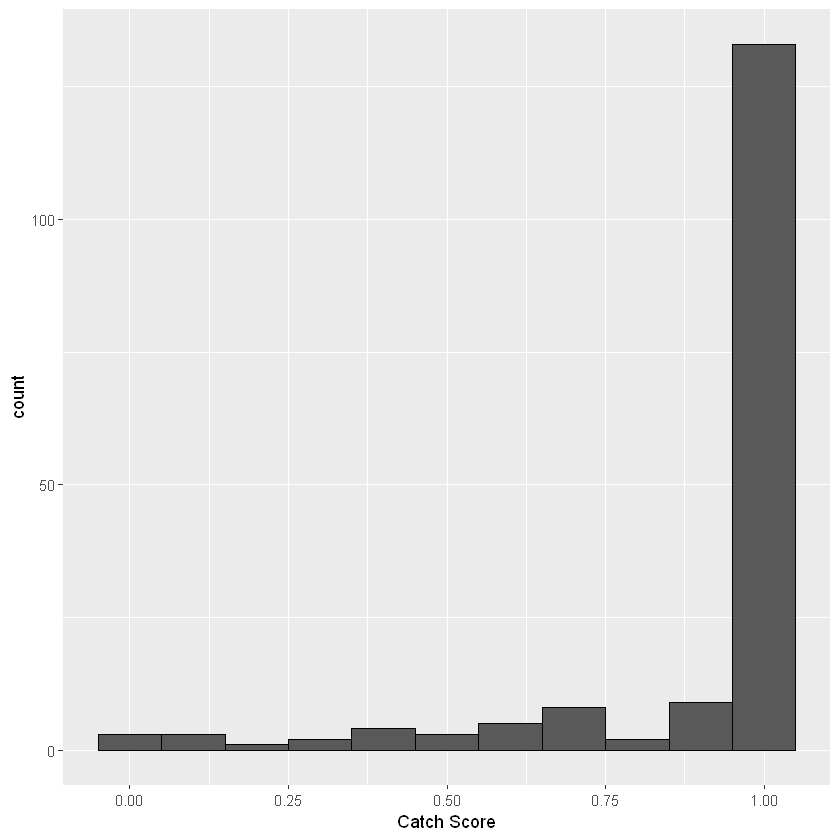

`geom_smooth()` using formula 'y ~ x'


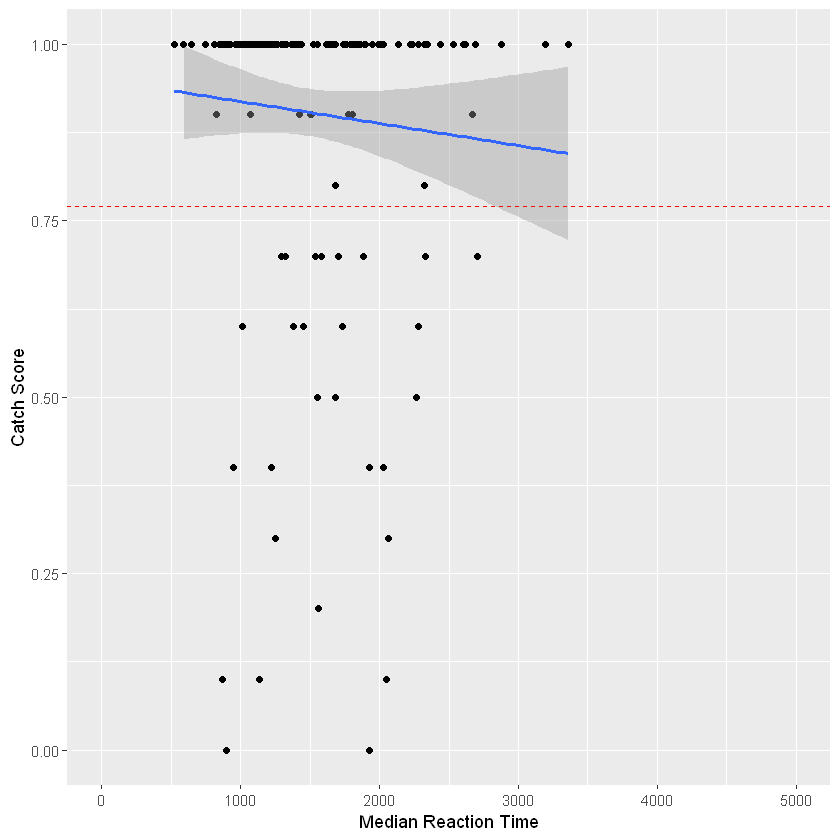

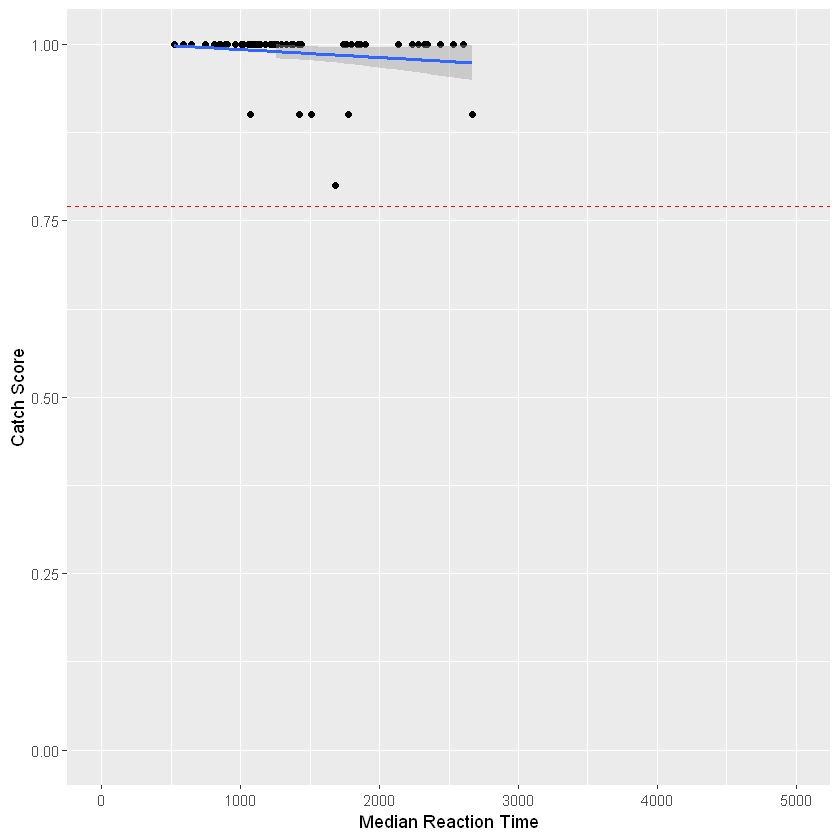

In [66]:
# Data quality check.
rt_hist(datadf)
rt_catch_plot(datadf)
rt_catch_plot(cleandf)


Only using the smallest and largest stimuli for this analysis, so get rid of the other subject groups

In [63]:
cleandf <- subset(cleandf, (stimulus_radius == 1) | (stimulus_radius == 0.05))

In [136]:
# invert subjects with a CC normalised trace greater than 3.5
# not to be used in the main analysis

invert.df <- function(df){
    
    out.df <- df[0,] # output df
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    for(ID in subjectlist){
        tempdf <- subset(df, subject == ID)
        if(norm.trace.cc(tempdf) > 3.5){
            tempdf$similarity <- abs(tempdf$similarity - max.DSR)
        }
        out.df <- rbind(out.df,tempdf)
    }
    return(out.df)
}

In [138]:
# For the pilot data only - inverting the dissimilarity responses of subjects who misunderstood the task instructions
inverted.df <- invert.df(cleandf)

In [142]:
invert.trace.df <- trace_obtainer(inverted.df)
invert.trace.df <- label(invert.trace.df)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


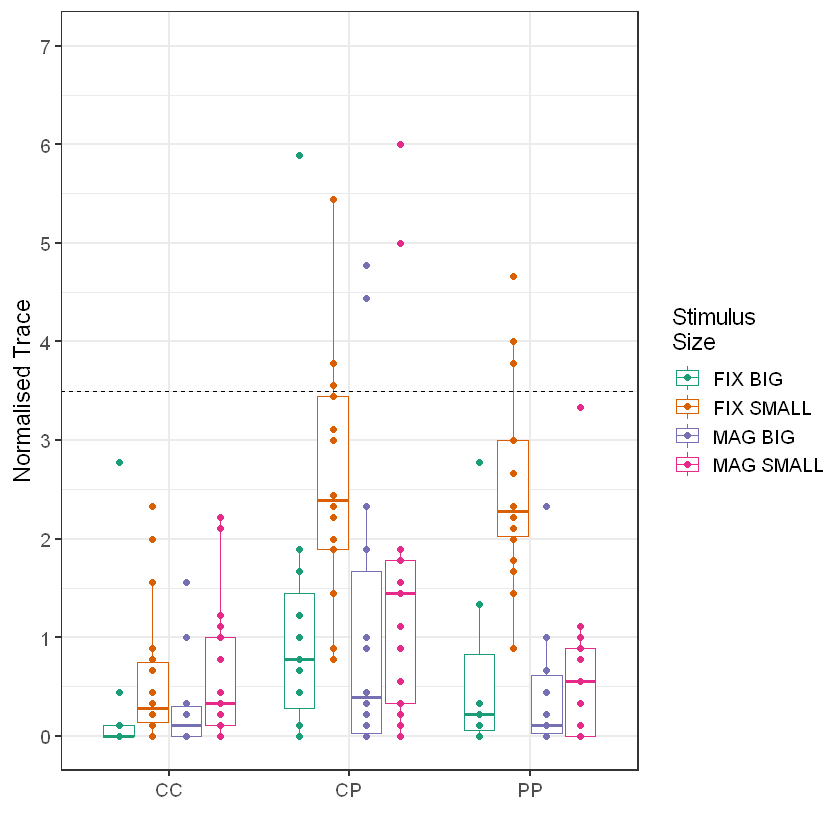

In [143]:
fig5b(invert.trace.df, save=FALSE)


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      PP ~ StimSize + Magnification + StimSize:Magnification
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 60

Estimates:
                         mean   sd   10%   50%   90%
(Intercept)             0.1    0.3 -0.2   0.1   0.5 
StimSize               -2.5    0.5 -3.1  -2.5  -1.8 
Magnification          -0.5    0.1 -0.7  -0.5  -0.4 
StimSize:Magnification  0.5    0.2  0.3   0.5   0.7 
(phi)                   5.7    1.1  4.3   5.6   7.1 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.2    0.0  0.1   0.2   0.2  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
                       mcse Rhat n_eff
(Intercept)            0.0  1.0  11875
StimSize               0.0  1.0   8353
Magnification   

Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter              |     BF
-------------------------------
(Intercept)            |  0.077
StimSize               | > 1000
Magnification          | > 1000
StimSize:Magnification |  20.62
(phi)                  | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Interaction: 4.35"
[1] "HPD: 2.79" "HPD: 4.57"


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      PP ~ StimSize + Magnification + StimSize:Magnification
 observations: 60
------
                       Median MAD_SD
(Intercept)             0.1    0.3  
StimSize               -2.5    0.5  
Magnification          -0.5    0.1  
StimSize:Magnification  0.5    0.2  
(phi)                   5.6    1.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

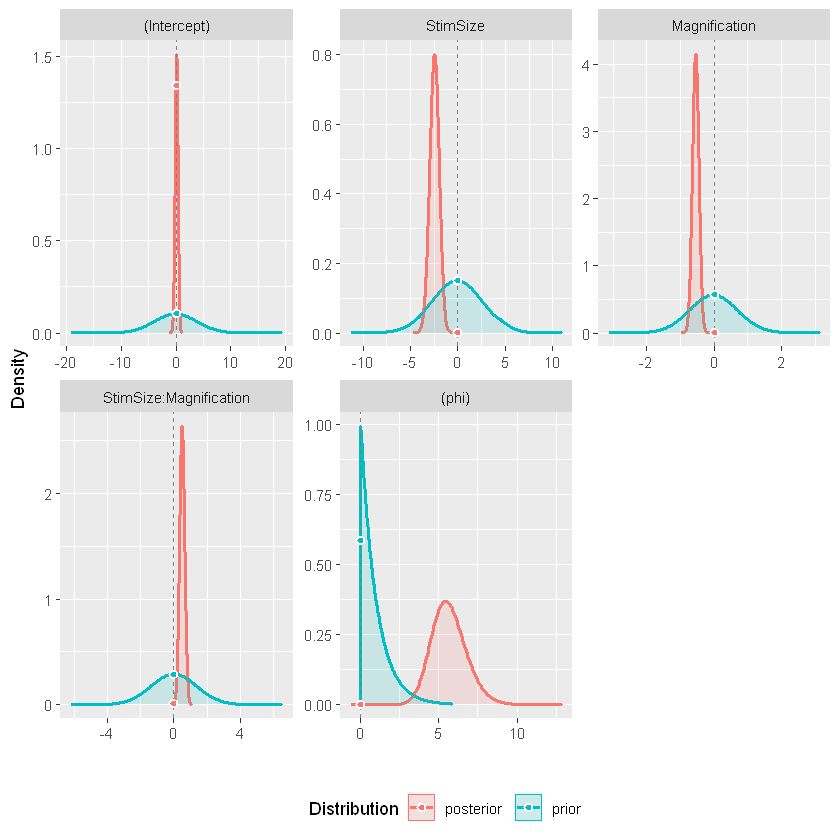

In [146]:
h1b(invert.trace.df,summary=TRUE)

[1] "Working on raw (6) values"


ERROR while rich displaying an object: Error: geom_hline requires the following missing aesthetics: yintercept

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.defa

ERROR: Error in h2b(invert.var.data): could not find function "h2b"


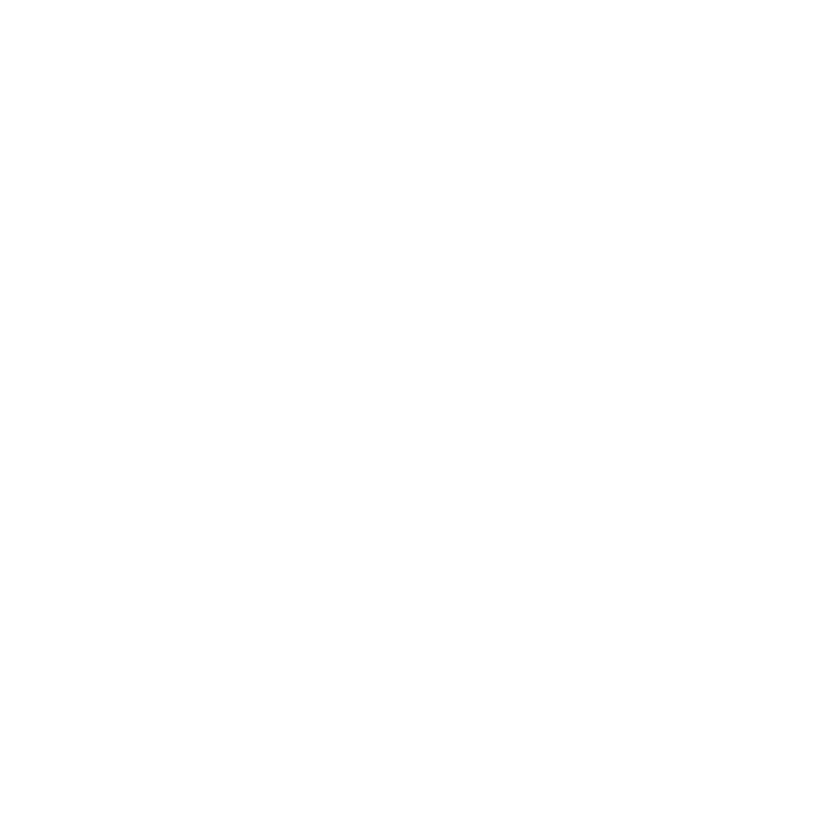

In [147]:
invert.var.data <- var.format(inverted.df)
invert.var.data <- label(var.data)


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 60
------
                       Median MAD_SD
(Intercept)            -0.9    0.2  
StimSize               -0.9    0.4  
Magnification          -0.2    0.1  
StimSize:Magnification  0.2    0.1  
(phi)                   8.0    1.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                             2.5%       97.5%
(Intercept)            -1.4033921 -0.43876703
StimSize               -1.8119605 -0.12405568
Magnification          -0.3534496 -0.03569502
StimSize:Magnification -0.1072492  0.40659297
(phi)                   5.4586802 11.35483243


Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter              |     BF
-------------------------------
(Intercept)            |  58.35
StimSize               |   2.08
Magnification          |   2.05
StimSize:Magnification |  0.183
(phi)                  | > 1000

* Evidence Against The Null: 0

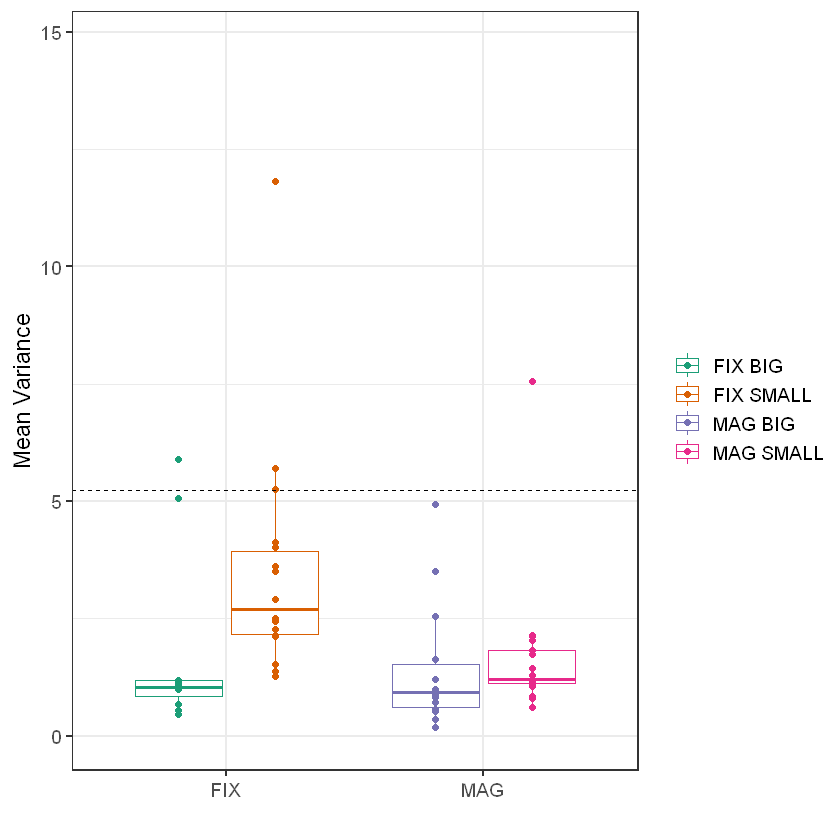

[1] ""
[1] "Converted back to Mean Variance"
[1] "Interaction: 7.9"
[1] "HPD: 2.9"  "HPD: 5.76"


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 60
------
                       Median MAD_SD
(Intercept)            -0.9    0.2  
StimSize               -0.9    0.4  
Magnification          -0.2    0.1  
StimSize:Magnification  0.2    0.1  
(phi)                   8.0    1.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

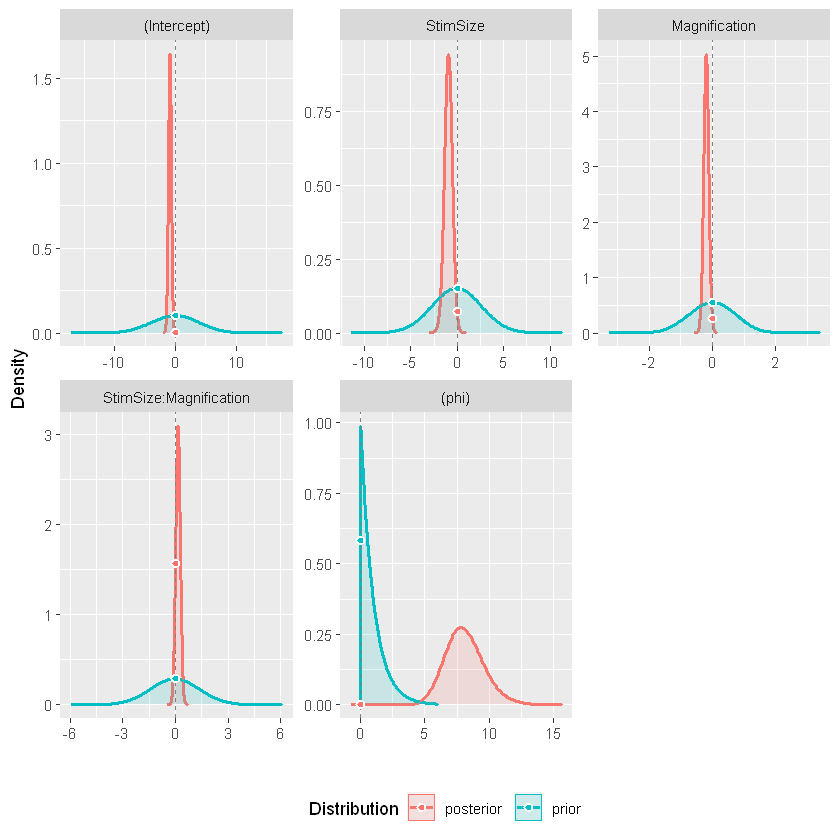

In [150]:
fig6d(invert.var.data,rand.var.mu,save=FALSE)
h2b(invert.var.data)

In [64]:
# N values
get_n.grouped(cleandf)

[1] "Magnification 1 Size 0.05  - N = 18"
[1] "Magnification 4.5 Size 0.05  - N = 17"
[1] "Magnification 1 Size 1  - N = 11"
[1] "Magnification 4.5 Size 1  - N = 14"


In [71]:
# label the data for plotting
label <- function(df,raw=FALSE){
    if(raw){
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$peripheral_scale != 1] <- 'MAG'
        df$label.mag[df$peripheral_scale == 1] <- 'FIX'
        df$label.stim[df$stimulus_radius != 1] <- 'SMALL'
        df$label.stim[df$stimulus_radius == 1] <- 'BIG'
        df$label.combo <- paste(df$label.mag, format((df$label.stim)))
    } else{
        df$label.mag <- NA
        df$label.stim <- NA
        df$label.combo <- NA
        df$label.mag[df$Magnification != 1] <- 'MAG'
        df$label.mag[df$Magnification == 1] <- 'FIX'
        df$label.stim[df$StimSize != 1] <- 'SMALL'
        df$label.stim[df$StimSize == 1] <- 'BIG'
        df$label.combo <- paste(df$label.mag, format((df$label.stim)))
    }
    
    return(df)
}

In [75]:
# make an MDS visualisation of each group
ds.mds <- function(df){
    
    # keep track of the plots
    plot.list <- list()
    k = 1
    
    # generate labels
    C <- c(rep('Central',9))
    P <- c(rep('Peripheral',9))
    Eccentricity <- c(C,P)
    colors2 <- c(colors,colors)
    
    scales <- unique(df$peripheral_scale)
    stims <- unique(df$stimulus_radius)
    for(scale in scales){
        for(stim in stims){
            mds.df <- subset(cleandf, peripheral_scale == scale & stimulus_radius == stim)
            mds.data <- dissimgroup2matlist(mds.df,sym=TRUE)
            mds.data <- group.mat.mean(mds.data)
            mds.data <- mat2dist(mds.data)
            mds.data <- cmdsfit(mds.data)
            mds.data <- as.data.frame(mds.data)
            mds.data$Eccentricity <- Eccentricity
            
            # get label
            lab <- mds.df$label.combo[1]
            
            #dissimilarity data plot
            #print(head(mds.df))
            mds.df <- group.dissim(mds.df,sym=TRUE) # average over the participants
            plot <- dissimplot.full(mds.df,
                                    dependent='dissimilarity')
            plot.list[[k]] <- as.grob(plot)
            k = k + 1
            
            #mds plot
            plot <- ggplot(mds.data, aes(x = V1, y = V2, color=colors2)) + geom_point(size =10,aes(shape=Eccentricity)) + 
                #geom_text(aes(label=tags, vjust=-2)) +
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(lab) + 
                #theme(legend.position='none') +
                scale_colour_identity() +
                theme(
                      plot.title = element_text(size = 27)
                        )
            plot.list[[k]] <- as.grob(plot)
            k = k + 1
            
            
        }
    }
    g <- arrangeGrob(grobs = plot.list, ncol=2, nrow=4)
    ggsave('descriptive_test.png',g,height=25.7,width=15)
    return(g)
}
cleandf <- label(cleandf,raw=TRUE)


In [76]:
ds.mds(cleandf)

TableGrob (4 x 2) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]
7 7 (4-4,1-1) arrange gtable[layout]
8 8 (4-4,2-2) arrange gtable[layout]

## Analysis Plan

### Visualisation of Hypothesis 1 Data

#### Useful functions

In [77]:
# function to perform boundary offsets for beta-distributed data
# suggested by http://doi.apa.org/getdoi.cfm?doi=10.1037/1082-989X.11.1.54
offset.beta <- function(vector, max.DSR){
    offset <- (vector * (length(vector)-1) + 0.5) / length(vector)
    return(offset/max.DSR)
}

In [139]:
# plot the data
fig5b <- function(df,save=TRUE){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    #plot.df$StimSize <- as.character(plot.df$StimSize)
    #plot.df$Magnification <- as.character(plot.df$Magnification)
    median <- median(subset(plot.df,Comparison=='PP')$value) # for connecting to hypothesis 1b
    
    plot <- ggplot(plot.df,aes(x = Comparison, y = value, 
                         #color = Magnification, 
                         #fill = StimSize
                         colour = label.combo
                                ),
                    size = 0.7) +
        geom_boxplot() +
        guides(colour=guide_legend(title="Stimulus\nSize")) +
        #scale_colour_manual(values = c("red","blue")) + 
        #scale_fill_manual(values = c("#E67E22","#1ABC9C"))
        geom_point(position=position_dodge(width=0.75)) +
        geom_hline(yintercept=3.5, linetype='dashed') +
        #geom_hline(yintercept=median, linetype = 'dashed',color='blue') +
        ylim(0,7) +
        theme_bw(base_size = 14) +
        xlab("") +
        #ylab("Normalised Trace") +
        scale_y_continuous(name='Normalised Trace',
                         breaks=c(0,1,2,3,4,5,6,7),
                         labels=c(0,1,2,3,4,5,6,7),
                         limits=c(0,7)) +
        scale_colour_brewer(palette='Dark2')
    
    
    if(save){
        ggsave('fig5b.png',plot,height=2.8,width=4)
    }
    return(plot)
}

In [79]:
fig5c <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- (plot.df$value)/max.DSR

    plot <- ggplot(plot.df, aes(x = value, fill=Comparison)) + 
        geom_density(aes(x=value,y=..scaled../3),alpha=0.375) +
        geom_histogram(aes(x=value,y=stat(count)/sum(count)*3), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=0.5, linetype='dashed') +
        xlab("Scaled Normalised Trace") +
        ylab("Density")
        
    ggsave('fig5c.png',plot,height=2.8,width=4)
    return(plot)
}

In [80]:
fig5c.rainbow <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- (plot.df$value)/max.DSR
    
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,fill=Comparison,colour=Comparison)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Comparison)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Normalised Trace') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=0.5, linetype='dashed') + geom_hline(yintercept=1.05)
    
    ggsave('fig5c_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [81]:
fig5d.rainbow <- function(df){
    
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df$value <- logit(offset.beta(plot.df$value,max.DSR))
    
    #pal <- c('#E67E22','#2ECC71','#B0B901')
    
    plot <- ggplot(plot.df,aes(x=Comparison,y=value,fill=Comparison,colour=Comparison)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Comparison)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Logistic-Transformed\nNormalised Trace') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(0.5), linetype='dashed') + ylim(-7.5,7.5)# +
            #scale_fill_manual(values=pal) + scale_colour_manual(values=pal)
    
    ggsave('fig5d_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [82]:
fig5f.rainbow <- function(df){
    plot.df <- pivot_longer(data = df, cols = c(CC,CP,PP), names_to = 'Comparison')
    plot.df <- subset(plot.df, Comparison == 'PP') # only keeping PP data
    plot.df$value <- logit(offset.beta(plot.df$value,max.DSR))
        
    plot <- ggplot(plot.df,aes(x=label.combo,y=value,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            geom_hline(yintercept=logit(0.5), linetype='dashed') +
            ylab("Logistic-Transformed\nNormalised Trace") + 
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            ylim(-7.5,7.5)  +
            scale_fill_brewer(palette='Dark2') + scale_colour_brewer(palette='Dark2')
    
    ggsave('fig5f_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

#### Do the visualisations

In [83]:
# obtain the data
trace.df <- trace_obtainer(cleandf)


In [153]:
# REMOVE THIS LATER
trace.df <- invert.trace.df

In [154]:
# label the data
trace.df <- label(trace.df)

In [155]:
# obtain the relevant data
trace.df.mag <- subset(trace.df, Magnification != 1)
#head(trace.df)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


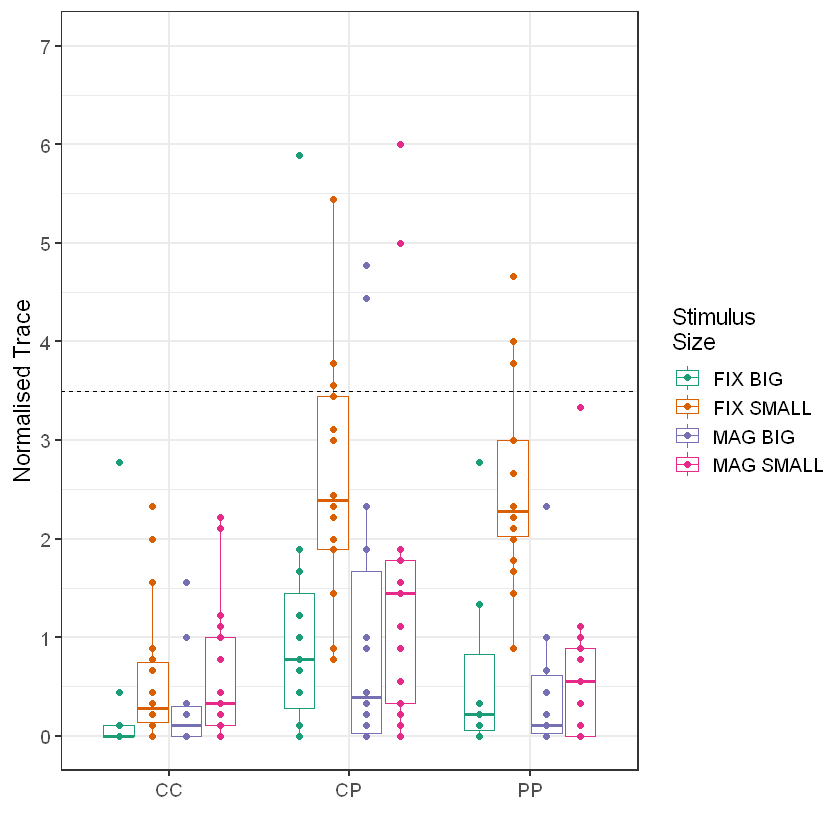

In [156]:
# plot the full data data
fig5b(trace.df)

In [157]:
#fig5c(trace.df.mag)

In [158]:
#fig5c.rainbow(trace.df.mag)

In [159]:
#fig5d(trace.df.mag)

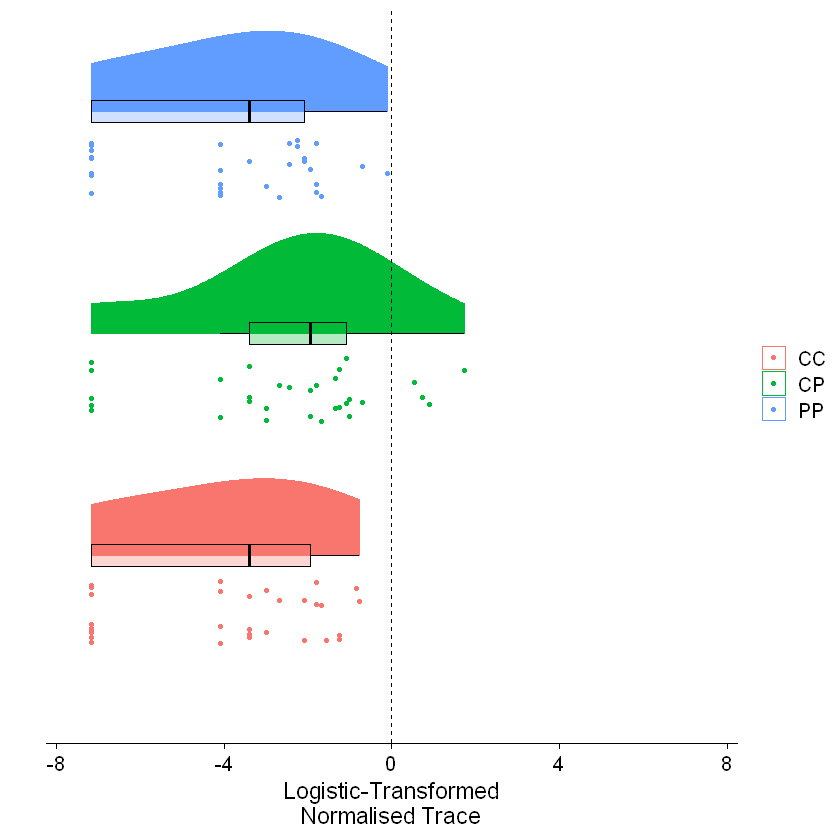

In [160]:
fig5d.rainbow(trace.df.mag)

In [161]:
#fig5e(trace.df)

In [162]:
#fig5e.rainbow(trace.df)

In [163]:
#fig5f(trace.df)

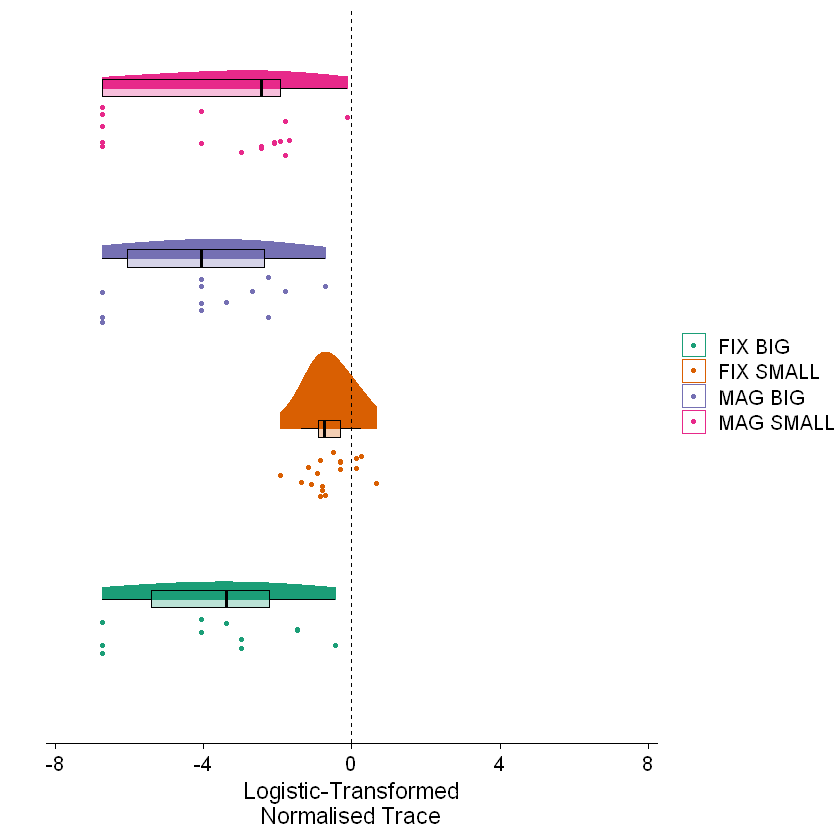

In [164]:
fig5f.rainbow(trace.df)

#### 1a) Do subjects respond that identical stimuli have zero dissimilarity when presented at each of CC, CP and PP?

For each subject, we obtained a dissimilarity value for the comparison of a colour stimulus to itself in each of the CC, CP and PP conditions. Are these dissimilarity values equal to zero, as would be expected? Is this true in all presentation conditions?  
  
If participants were randomly selecting these values, the mean dissimilarity across the colour pair comparisons would be mean of a random sample for the dissimilarity values. As these range from 0 to 7, this would be 3.5  
  
We will test to see if the mean dissimilarity for these values is less than 3.5 in data from subjects in the peripherally magnified conditions. We'll examine this for each of CC, CP and PP comparisons. Going to use a Bayesian beta-regression for each one.

In [165]:
# Function to test hypothesis 1a
h1a <- function(data,summary=FALSE){
    data <- offset.beta(data,max.DSR)
    df <- as.data.frame(data)
    
    model.test <- stan_betareg(
                formula = data ~ 1,
                data = df,
                iter=10000, # helps to stabilise the estimates
                refresh=0
                )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Normalised Trace")
    intercept <- model.test[[1]][1]
    print(paste('Intercept:',round(undo.logit(intercept,max.DSR),2)))
    print(paste('HPD:',round(undo.logit(HPD[1,],max.DSR),2)))
    return(model.test)
}

In [166]:
# convert logistic intercept values back to human-intelligible numbers
undo.logit <- function(x,max){
    return(inv.logit(x)*max)
}


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 31

Estimates:
              mean   sd   10%   50%   90%
(Intercept) -2.3    0.3 -2.6  -2.3  -1.9 
(phi)        4.7    1.4  3.1   4.5   6.5 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.1    0.0  0.1   0.1   0.1  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse Rhat n_eff
(Intercept)   0.0  1.0  5569 
(phi)         0.0  1.0  6083 
mean_PPD      0.0  1.0  8415 
log-posterior 0.0  1.0  5908 

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size, and Rhat is the potential scale reduction factor on split chains (at convergence Rhat=1).
                 2.5%  

Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter   |     BF
--------------------
(Intercept) | > 1000
(phi)       | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: 0.65"
[1] "HPD: 0.42" "HPD: 1.05"


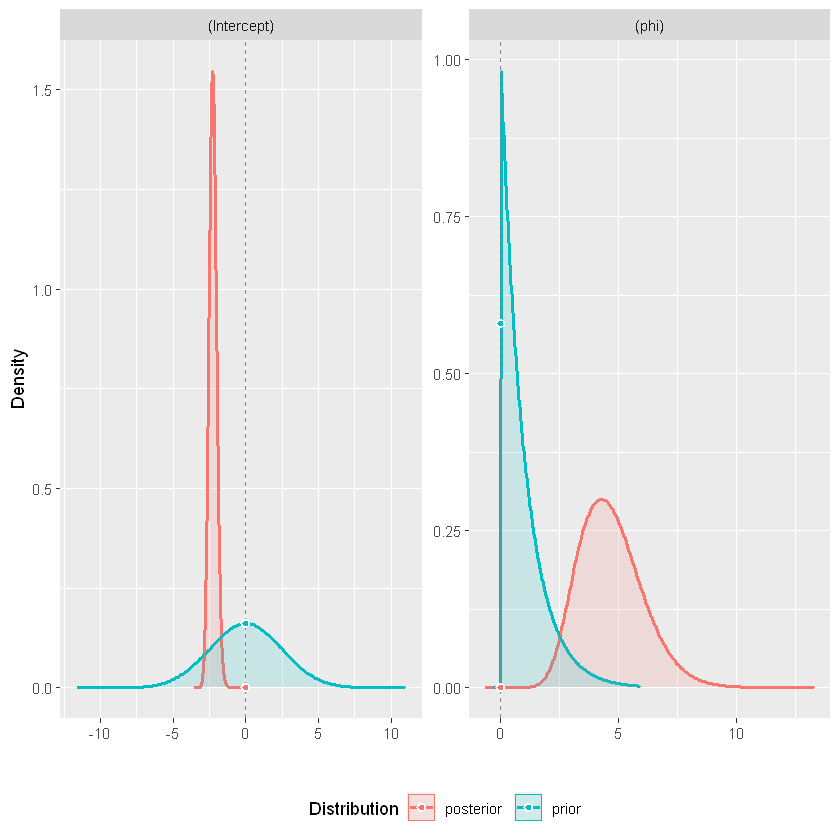

In [167]:
# test CC
h1a.cc <- h1a(trace.df.mag$CC,summary=TRUE)

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 31
------
            Median MAD_SD
(Intercept) -1.3    0.2  
(phi)        2.3    0.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                 2.5%     97.5%
(Intercept) -1.785663 -0.856313
(phi)        1.372306  3.563512


Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter   |     BF
--------------------
(Intercept) | > 1000
(phi)       | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: 1.46"
[1] "HPD: 1.01" "HPD: 2.09"


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 31
------
            Median MAD_SD
(Intercept) -1.3    0.2  
(phi)        2.3    0.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

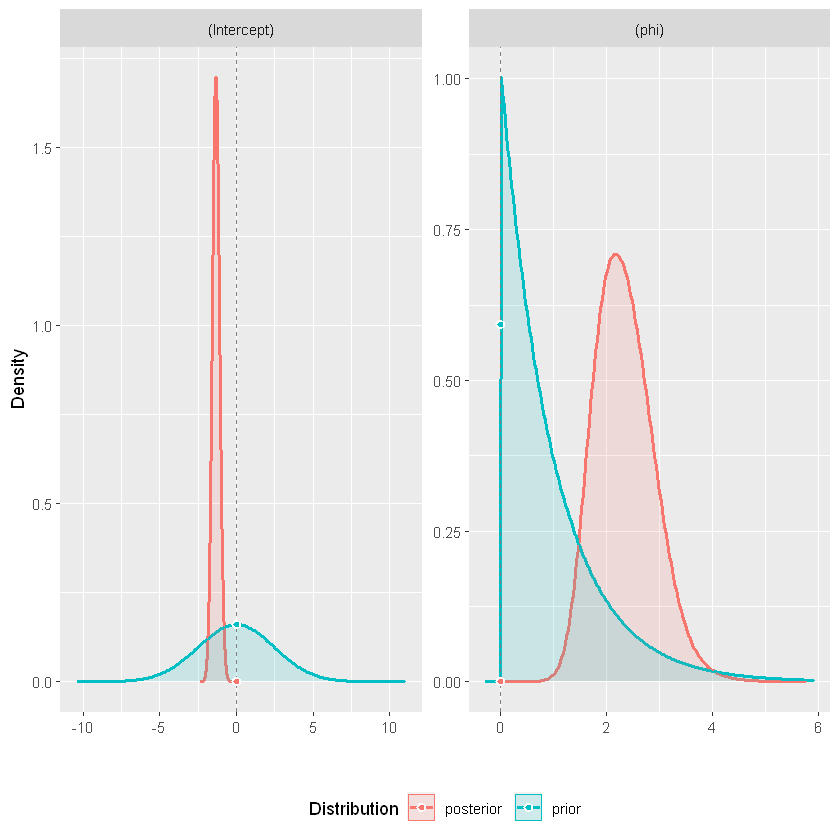

In [168]:
# test CP
h1a(trace.df.mag$CP)


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 31
------
            Median MAD_SD
(Intercept) -2.2    0.3  
(phi)        4.5    1.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                 2.5%     97.5%
(Intercept) -2.706644 -1.699897
(phi)        2.410195  7.555085


Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter   |     BF
--------------------
(Intercept) | > 1000
(phi)       | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Intercept: 0.68"
[1] "HPD: 0.44" "HPD: 1.08"


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      data ~ 1
 observations: 31
------
            Median MAD_SD
(Intercept) -2.2    0.3  
(phi)        4.5    1.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

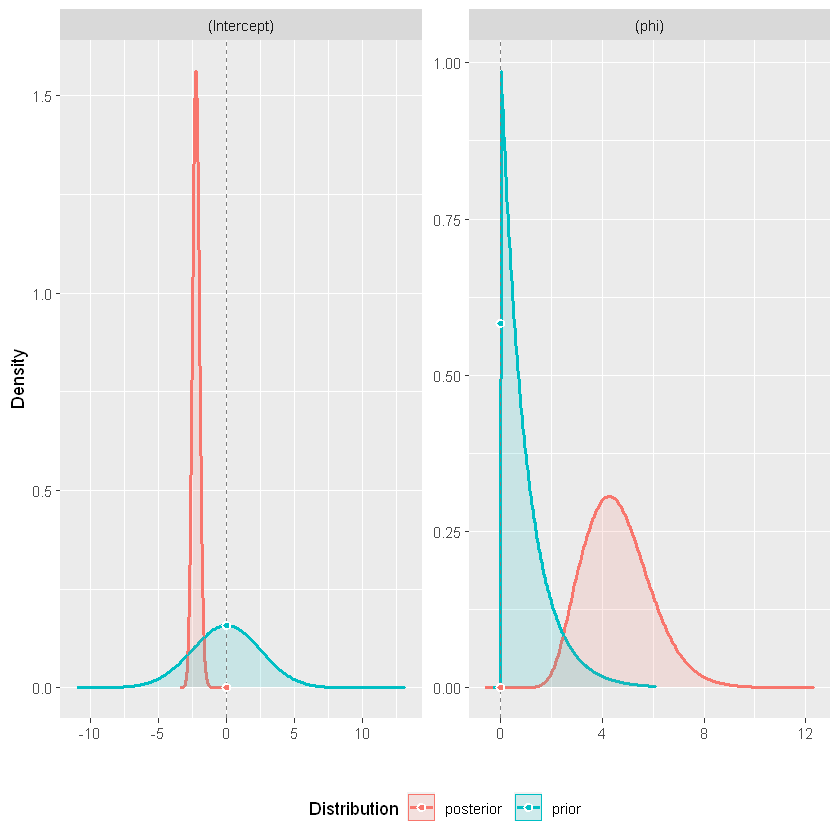

In [169]:
# test PP
h1a(trace.df.mag$PP)

#### 1b) Are dissimilarity ratings for identical stimuli presented in the periphery affected by peripheral magnification?

On the basis of previous psychophysics work we suspect that small stimuli in the periphery may induce altered or unstable colour experiences compared to larger stimuli. We also suspect that appropriately 'cortically magnified' stimuli should provide stable similarity judgments regardless of size. Thus, we hypothesise that there will be a Size x Magnification interaction effect on dissimilarity ratings made in the PP condition.  
  
As we are taking the average over non-negative values with a heavy preponderance of zeros bounded on both sides, the data will be beta-distributed. Thus, we are fitting the data using a Bayesian beta regression.

In [170]:
# Bayesian version of the beta-regression, for sample analysis as well
h1b <- function(data,summary=FALSE){
    
    # normalisation and boundary offset as suggested in Smithson and Verkuilen (2006)
    data$PP <- offset.beta(data$PP,max.DSR)
    
    # bayesian stuff
    model.test <- stan_betareg(formula = PP ~ StimSize + Magnification + StimSize:Magnification,
                data = data,
                iter=10000, # helps to stabilise the estimates
                refresh=0
                )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Normalised Trace")
    interaction <- model.test[[1]][4]
    print(paste('Interaction:',round(undo.logit(interaction,max.DSR),2)))
    print(paste('HPD:',round(undo.logit(HPD[1,],max.DSR),2)))
    
    return(model.test)
}

In [171]:
# testing what would happen if inverted subjects were excluded
#h1b(rbind(exclude.trace,exclude.trace),summary=TRUE)


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      PP ~ StimSize + Magnification + StimSize:Magnification
 algorithm:    sampling
 sample:       20000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 60

Estimates:
                         mean   sd   10%   50%   90%
(Intercept)             0.1    0.3 -0.2   0.1   0.5 
StimSize               -2.5    0.5 -3.1  -2.5  -1.9 
Magnification          -0.5    0.1 -0.7  -0.5  -0.4 
StimSize:Magnification  0.5    0.2  0.3   0.5   0.7 
(phi)                   5.7    1.1  4.3   5.6   7.2 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.2    0.0  0.1   0.2   0.2  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
                       mcse Rhat n_eff
(Intercept)            0.0  1.0  11169
StimSize               0.0  1.0   8307
Magnification   

Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter              |     BF
-------------------------------
(Intercept)            |  0.077
StimSize               | > 1000
Magnification          | > 1000
StimSize:Magnification |  19.81
(phi)                  | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Normalised Trace"
[1] "Interaction: 4.37"
[1] "HPD: 2.79" "HPD: 4.57"


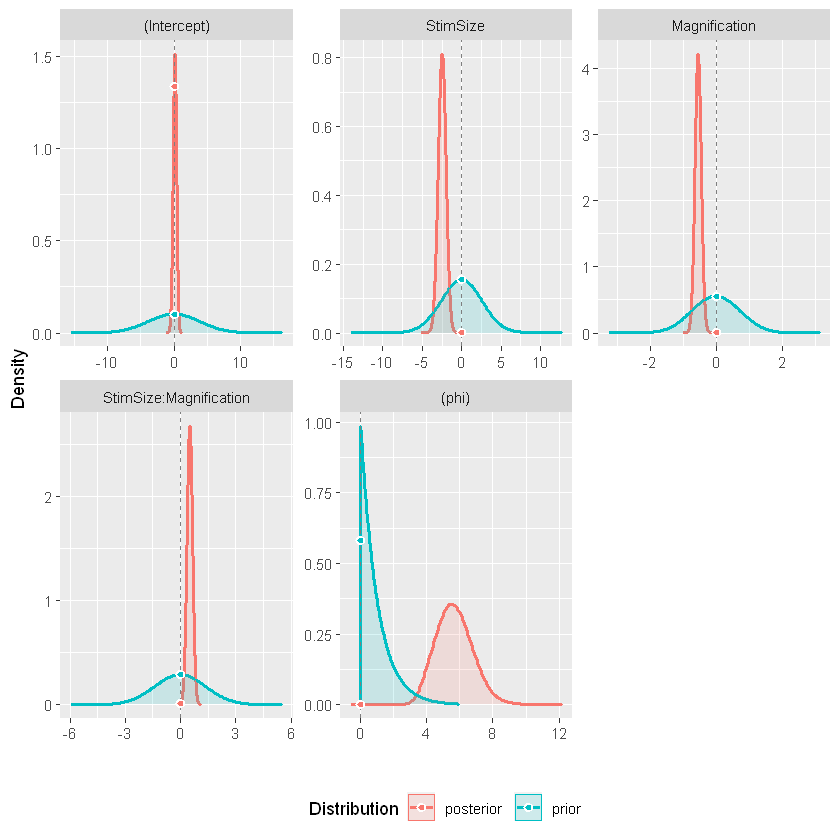

In [172]:
# test all the data
h1b.model <- h1b(trace.df,summary=TRUE)

### Visualisation of Hypothesis 2 Data

#### Useful functions

In [103]:
# get the mean variance of colour comparisons
var.color <- function(df,diagnose=FALSE,sym=sym){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat.full(df, l2e('Central'), l2e('Central'),sym=sym)
    fpmatrix <- df2mat.full(df, l2e('Central'), l2e('Peripheral'),sym=sym)
    pmatrix <- df2mat.full(df, l2e('Peripheral'), l2e('Peripheral'),sym=sym)
    
    # calculate the variance for each colour
    colour.vars <- vector()
    # calculate differently based on whether data is symmeterised or not
    if(sym){ # symmeterised
        
        
        # turn the matrices into vectors
        ff.v <- fmatrix[upper.tri(fmatrix,diag=TRUE)]
        fp.v <- fpmatrix[upper.tri(fpmatrix,diag=TRUE)]
        pp.v <- pmatrix[upper.tri(pmatrix,diag=TRUE)]
        
        for(i in 1:length(ff.v)){
            colour.vars[i] <- var(c(ff.v[i],fp.v[i],pp.v[i]))
        }
    } else { # raw, unsymmeterised
        i = 1
        ff.upper.v <- vector()
        fp.upper.v <- vector()
        pp.upper.v <- vector()
        ff.lower.v <- vector()
        fp.lower.v <- vector()
        pp.lower.v <- vector()
        for(row in 1:(nrow(fmatrix))){
            for(col in 1:(ncol(fmatrix))){
                if(row < col){ # I am aware this is wasteful, but it's easy
                    ff.upper.v[i] <- fmatrix[row,col]
                    fp.upper.v[i] <- fpmatrix[row,col]
                    pp.upper.v[i] <- pmatrix[row,col]
                    
                    ff.lower.v[i] <- fmatrix[col,row]
                    fp.lower.v[i] <- fpmatrix[col,row]
                    pp.lower.v[i] <- pmatrix[col,row]
                    
                    i = i + 1
                } 
            }
        }
        
        if(diagnose){
            print("upper")
            print(ff.upper.v)
            print(length(ff.upper.v))
            print("lower")
            print(ff.lower.v)
            print(length(ff.lower.v))
        }
        
        for(i in 1:length(ff.upper.v)){
            vals <- c(ff.upper.v[i],ff.lower.v[i],
                         fp.upper.v[i],fp.lower.v[i],
                         pp.upper.v[i],pp.lower.v[i])
            colour.vars[i] <- var(vals)
        }
        
    }
    
    
    if(diagnose){
        print("Variance values")
        print(colour.vars)
    }
    
    # get the mean variance
    var.mean <- mean(colour.vars)
    
    return(var.mean)
}

In [104]:
# get the data in the right format
var.format <- function(df,sym=FALSE){
    subjectlist <- sort(unique(df$subject)) # obtain a list of all the subjects
    
    if(sym){
            print('Working on symmeterised (3) values')
        } else {
            print('Working on raw (6) values')
        }
    
    # format for output
    out.df <- data.frame(subject=character(),
                        mean.var=double(),
                        stim_size=double(),
                        magnification=double())
    # extract the data
    for(ID in subjectlist){
        tempdf <- subset(df, subject == ID)
        stim <- unique(tempdf$stimulus_radius)[1]
        mag <- unique(tempdf$peripheral_scale)[1]
        val <- var.color(tempdf,sym=sym)
        row_df <- data.frame(ID, val, stim, mag)
        names(row_df) <- c("subject",'mean.var','StimSize','Magnification')
        out.df <- rbind(out.df,row_df)
    }
    return(out.df)
}

In [128]:
# calculate the mean variance for each color for plotting purposes
fig6bc <- function(df,name,tri=TRUE){
    # convert the data
    mats <- dissimgroup2matlist(df,sym=TRUE)
    mats.var <- full2var.mats(mats)
    mat <- group.mat.median(mats.var)
    
    # get rid of the lower half
    if(tri){
        mat[lower.tri(mat)] <- NA
    }
    
    
    data <- melt(mat)
    colnames(data) <- c('color1.eccen1','color2.eccen2','Variance')
    
    plot <- ggplot(data, aes(x = color1.eccen1, y = color2.eccen2)) + 
                    geom_raster(aes(fill = Variance)) +
                    scale_fill_gradientn(colours = c("blue","yellow"),
                                    limits=c(0,6), na.value='white'
                                    #breaks=c(0,1,2,3,4,5,6,7)
                                        ) +
                    # colours
                   theme(axis.text.x = element_text(colour=colors,angle=90),
                          axis.text.y = element_text(colour=colors),
                          axis.title.x = element_blank(), axis.title.y = element_blank(),
                          plot.title = element_text(hjust = 0.5)) +
                    scale_colour_identity()
    
    ggsave(name,plot,height=2.8,width=3.75)
    return(plot)
}

In [106]:
fig6d <- function(plot.df,rand.var.mu,histogram=FALSE,save=TRUE){
    
    plot.df$StimSize <- as.character(plot.df$StimSize)
    plot.df$Magnification <- as.character(plot.df$Magnification)
    
    plot <- ggplot(plot.df) +
        geom_boxplot(aes(x = Magnification, y = mean.var, 
                         color = label.combo)) +
        geom_point(aes(x = Magnification, y = mean.var, 
                         color = label.combo),
                  position=position_dodge(width=0.75)) +
        geom_hline(yintercept=rand.var.mu, linetype='dashed') +
        #geom_hline(yintercept=median(plot.df$mean.var),linetype='dashed',color='blue') +
        scale_x_discrete(labels=c("FIX",'MAG')) +
        theme_bw(base_size = 14) +
        #guides(color=guide_legend(title="Stimulus\nSize")) +
        guides(color=guide_legend(title="")) +
        xlab("") +
        ylab("Mean Variance") +
        ylim(0,max(vals)) +
        #scale_colour_manual(values = c("orange",'purple')) +
        scale_color_brewer(palette='Dark2') + scale_fill_brewer(palette='Dark2') 
    if(histogram){
        #plot.df$mean.var <- log((plot.df$mean.var))
        plot.df$label.combo <- paste(plot.df$StimSize,plot.df$Magnification)
        hist.plot <- ggplot(plot.df, aes(x = mean.var, fill=label.combo)) + geom_histogram(binwidth=0.25)
        return(hist.plot)
    }
    if(save){
        ggsave('fig6d.png',plot,height=2.8,width=4)
    }
    
    return(plot)
}

In [107]:
fig6e <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,max(vals))

    plot <- ggplot(df, aes(x = mean.var,fill=Magnification)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=rand.var.mu/max(vals), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Scaled Mean Variance") +
        ylab("Density") +
        xlim(-0.05,1) +
        theme(legend.position='none')
        
    ggsave('fig6e.png',plot,height=2.8,width=4)
    return(plot)
} 

In [108]:
fig6e.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,max(vals))
    
    plot <- ggplot(df,aes(x=Magnification,y=mean.var,fill=Magnification,colour=Magnification)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=4.5 + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Mean Variance') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=rand.var.mu/max(vals), linetype='dashed') +  geom_hline(yintercept=1.05)
    
    ggsave('fig6e_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [109]:
fig6f <- function(df,rand.var.mu,vals){
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,max(vals)))

    plot <- ggplot(df, aes(x = mean.var,fill=Magnification)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        #geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=logit(rand.var.mu/max(vals)), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Logistic-Transformed\nMean Variance") +
        ylab("Density") +
        xlim(-7.5,3) +
        theme(legend.position='none')
        
    ggsave('fig6f.png',plot,height=2.8,width=4)
    return(plot)
}

In [110]:
fig6f.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,max(vals)))
    
    plot <- ggplot(df,aes(x=Magnification,y=mean.var,fill=Magnification,colour=Magnification)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=4.5 + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-Transformed\nMean Variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(rand.var.mu/max(vals)), linetype='dashed')
    
    ggsave('fig6f_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [111]:
fig6g <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,max(vals))

    plot <- ggplot(df, aes(x = mean.var,fill=label.combo)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=rand.var.mu/max(vals), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Scaled Mean Variance") +
        ylab("Density") +
        xlim(-0.05,1)
        
    ggsave('fig6g.png',plot,height=2.8,width=4)
    return(plot)
} 

In [112]:
fig6g.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- offset.beta(df$mean.var,max(vals))
    
    plot <- ggplot(df,aes(x=label.combo,y=mean.var,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab('Scaled Mean Variance') + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=rand.var.mu/max(vals), linetype='dashed') +  geom_hline(yintercept=1.05)
    
    ggsave('fig6g_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

In [113]:
fig6h <- function(df,rand.var.mu,vals){
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,max(vals)))

    plot <- ggplot(df, aes(x = mean.var,fill=label.combo)) + 
        geom_density(aes(x=mean.var,y=..scaled..),alpha=0.375) +
        #geom_histogram(aes(x=mean.var,y=stat(count)/sum(count)), colour='black', binwidth=0.05,position="identity",alpha=0.5) +
        geom_vline(xintercept=logit(rand.var.mu/max(vals)), linetype='dashed') + # put the random line in, appropriately scaled
        xlab("Logistic-Transformed\nMean Variance") +
        ylab("Density") +
        xlim(-7.5,3)
        
    ggsave('fig6h.png',plot,height=2.8,width=4)
    return(plot)
}

In [114]:
fig6h.rainbow <- function(df,rand.var.mu,vals){
    
    # perform beta offset
    df$mean.var <- logit(offset.beta(df$mean.var,max(vals)))
    
    plot <- ggplot(df,aes(x=label.combo,y=mean.var,fill=label.combo,colour=label.combo)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(label.combo)) + 0.25, y = mean.var),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-Transformed\nMean Variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(rand.var.mu/max(vals)), linetype='dashed') +
            scale_color_brewer(palette='Dark2') + scale_fill_brewer(palette='Dark2')
    
    ggsave('fig6h_rainbow.png',plot,height=2.8,width=4)
    return(plot)
}

#### Do the visualisations

In [115]:
# get the data we want
var.data <- var.format(cleandf,sym=FALSE)
#head(var.data)
var.data.mag <- subset(var.data, Magnification != 1)


[1] "Working on raw (6) values"


In [116]:
# label the data
var.data <- label(var.data)

In [117]:
# simulating random selection
# updated method based on including symmeterisation
sim.rand.var <- function(method='sym'){
    dis.v <- c(0:7)
    if(method=='sym'){
        # taking the mean of the values as expected by symmeterisation procedure
        # this is more faithful to what random data fed into the preprocessing 
        # procedure would look like
        vals <- vector()
        for(i in 1:10000){
            CC <- mean(sample(dis.v, 2, replace=TRUE))
            PP <- mean(sample(dis.v, 2, replace=TRUE))
            CP <- mean(sample(dis.v, 2, replace=TRUE))
            PC <- mean(sample(dis.v, 2, replace=TRUE))
            CP.sym <- mean(c(CP,PC))
                        
            x <- var(c(CC,PP,CP.sym))
            
            
            vals <- c(vals,x)
            
        }
        
        
    } else {
        # pick n random dissimilarity values
        # 3 = equivalent to 1 CC, 1 PP and 1 CP values
        # 6 = equivalent to 2 CC, 2 PP and 2 CP values
        # 8 = equivalent to 2 CC, 2 PP and 4 CP values
        vals <- replicate(10000,var(sample(dis.v, method, replace=TRUE)))
    }
    print(method)
    print(paste("Mean variance of random selection:",mean(vals)))
    print(paste("SD of mean variance of random selection:",sd(vals)))
    return(vals)
}
#vals <- sim.rand.var()
#vals <- sim.rand.var(method=3)
vals <- sim.rand.var(method=6)
#vals <- sim.rand.var(method=8)

rand.var.mu <- mean(vals)
rand.var.sd <- sd(vals)

[1] 6
[1] "Mean variance of random selection: 5.22541333333333"
[1] "SD of mean variance of random selection: 2.28483925774976"


In [118]:
# supplementary figure of how random selection variance is distributed
sup.fig5a <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    plot <- ggplot(df, aes(x=vals,y=..density..)) + geom_histogram(binwidth=1/3,colour='black') + #geom_density(aes(fill=Variance),alpha=0.3) +
        geom_vline(xintercept=mu,linetype='dashed') + guides(fill=FALSE) +
        xlab("Variance") + ylab("Proportion")
    ggsave('supfig5a.png',plot,height=4,width=5.3)
    return(plot)
}

sup.fig5b <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    
    plot.scaled <- ggplot(df,aes(x=Variance,y=vals,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Scaled variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu, linetype='dashed') + ylim(0,1)
    
    ggsave('supfig5b.png',plot.scaled,height=4,width=5.3)
    return(plot.scaled)
}

sup.fig5c <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    df$vals.logit <- logit(df$vals)
    mu.logit <- logit(mu)

    plot.logit <- ggplot(df,aes(x=Variance,y=vals.logit,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals.logit),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-transformed variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu.logit, linetype='dashed')
    
    ggsave('supfig5c.png',plot.logit,height=4,width=5.3)
    return(plot.logit)
}



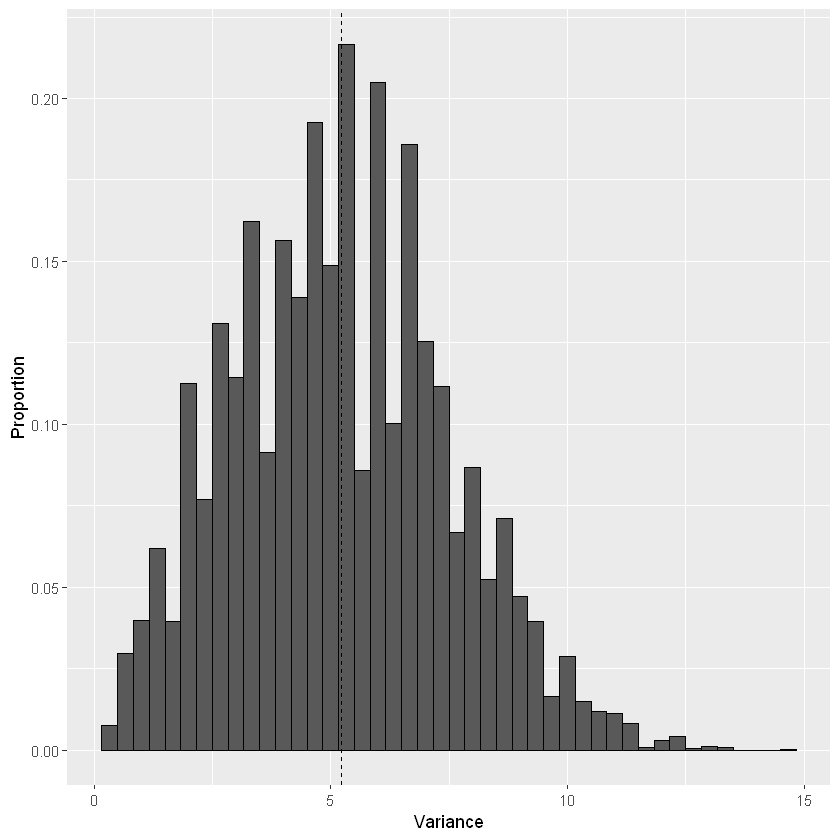

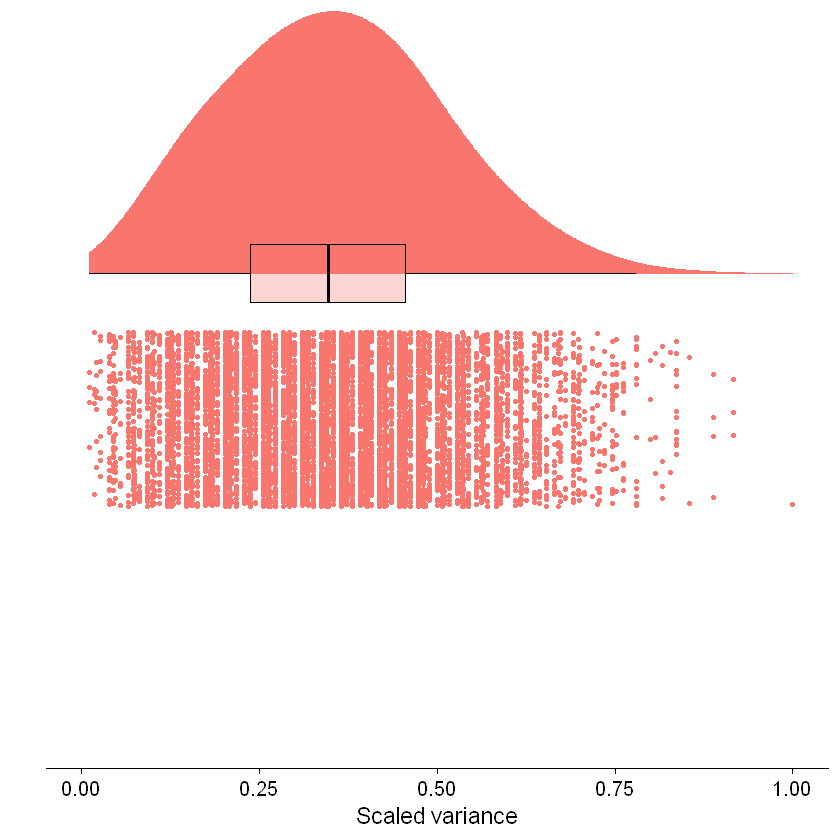

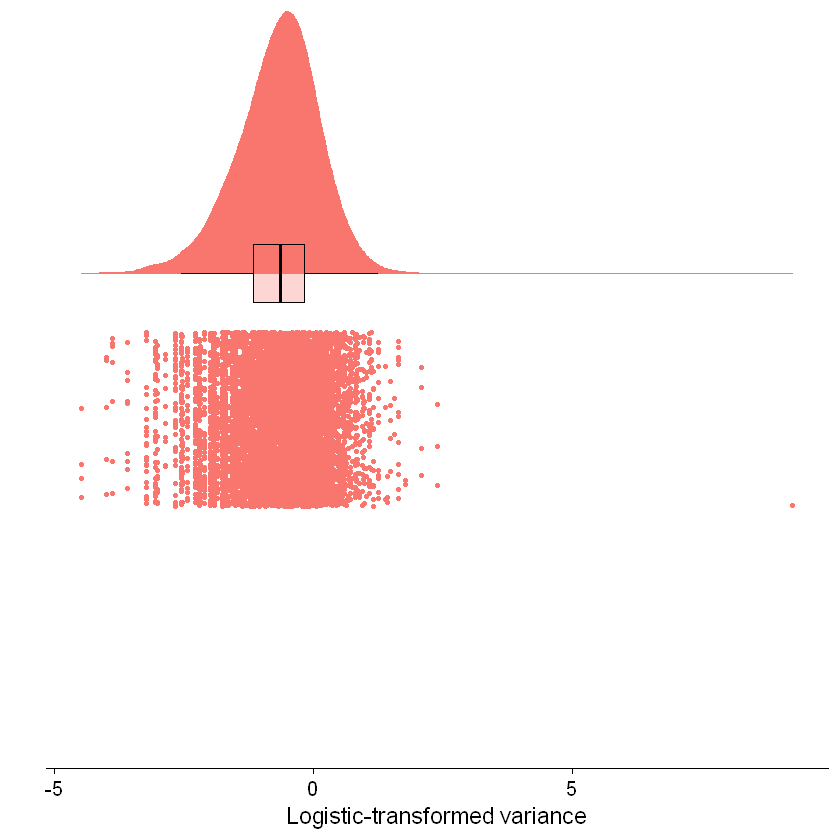

In [119]:
sup.fig5a(vals)
sup.fig5b(vals)
sup.fig5c(vals)

In [120]:
sup.fig5.raincloud <- function(vals){
    mu <- mean(vals)
    df <- as.data.frame(vals)
    df$Variance <- 'Variance'
    df$vals <- offset.beta(df$vals,max(vals))
    df$vals.logit <- logit(df$vals)
    mu.logit <- logit(mu)
    
    plot.scaled <- ggplot(df,aes(x=Variance,y=vals,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Scaled variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu, linetype='dashed') + ylim(0,1)
    

    plot.logit <- ggplot(df,aes(x=Variance,y=vals.logit,fill=Variance,colour=Variance)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(Variance))+ 0.25, y = vals.logit),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Logistic-transformed variance") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE,colour=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=mu.logit, linetype='dashed')
    
    g <- arrangeGrob(as.grob(plot.scaled),as.grob(plot.logit),ncol=1,nrow=2)
    ggsave('supfig5_raincloud.png',g,height=8,width=5.3)
}
sup.fig5.raincloud(vals)

In [126]:
head(mag.df)

,stimulus_radius,central_radius,peripheral_radius,build,date,time,subject,group,blockcode,blocknum,...,ratio_pxpermm.1,radius_F,radius_P,r_F,peripheral_scale,eccen_type,noncompliant,label.mag,label.stim,label.combo
3689,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,14,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG
3690,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,15,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG
3691,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,16,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG
3692,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,17,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG
3693,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,18,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG
3694,1,1,10,6.2.1,26/08/2020,15:08:55,513963865,789715452,experiment,19,...,4.3224299065420561661px,42.8090448650540906783px,428.0904486505409067831px,42.8090448650540906783px,4.5,CP,0,MAG,BIG,MAG BIG


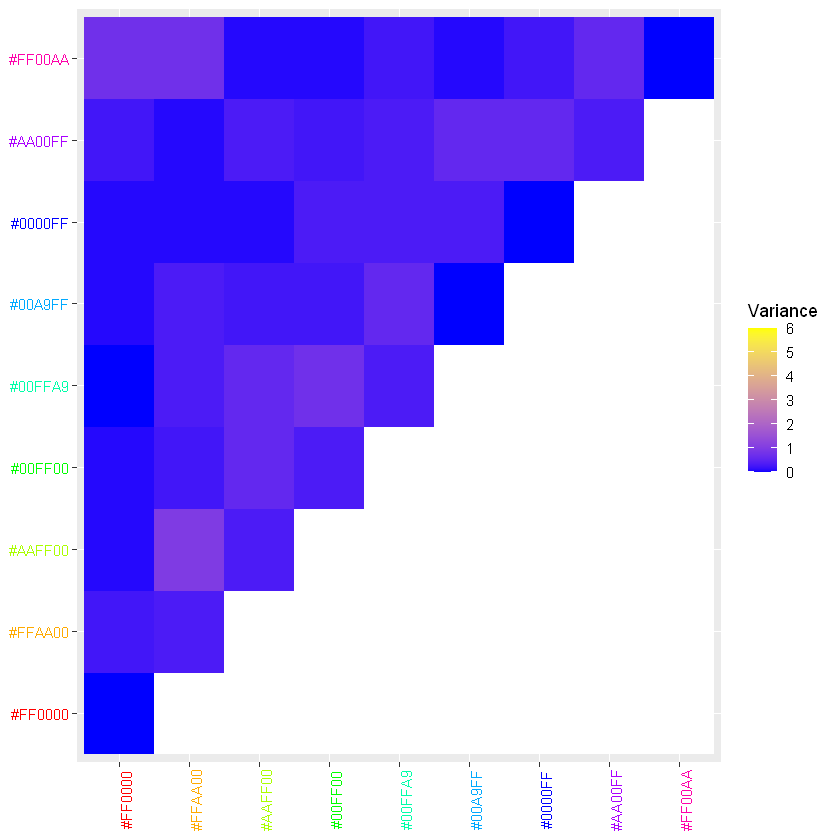

In [132]:
mag.df <- subset(cleandf, peripheral_scale != 1)
fig6bc(mag.df,name='fig6c.png',tri=TRUE)

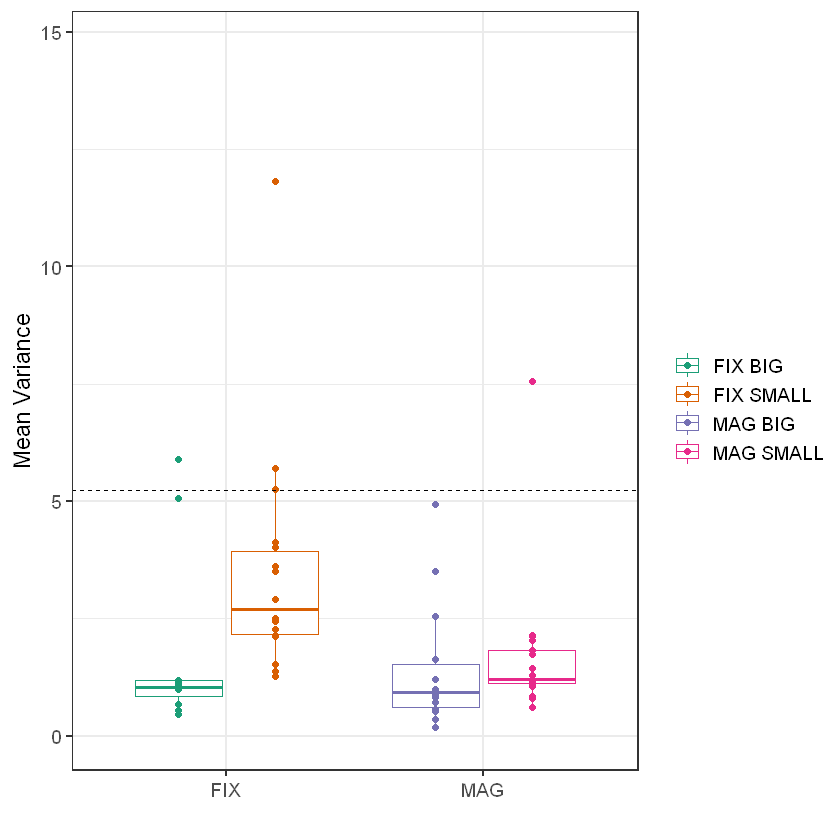

In [151]:
fig6d(var.data,rand.var.mu)

In [ ]:
#fig6e(var.data.mag,rand.var.mu,vals)
fig6e.rainbow(var.data.mag,rand.var.mu,vals)

In [ ]:
#fig6f(var.data.mag,rand.var.mu,vals)
fig6f.rainbow(var.data.mag,rand.var.mu,vals)

In [ ]:
#fig6g(var.data,rand.var.mu,vals)
fig6g.rainbow(var.data,rand.var.mu,vals)

In [ ]:
#fig6h(var.data,rand.var.mu,vals)
fig6h.rainbow(var.data,rand.var.mu,vals)

#### 2a) Do colour-pair comparisons made in CC, CP and PP conditions all generate the same dissimilarity ratings?

Going beyond whether identical physical stimuli elicit zero dissimilarity, we want to know whether the same pair of colours elicits the same dissimilarity value for a given subject whether it's presented in a CC, CP or PP condition.  
  
For each colour comparison a subject makes (e.g. RED-BLUE), we will calculate the variance between their CC, CP and PP responses. We will then take the mean variance across all of these colour comparisons for a given subject and use that as a measure of consistency.  
  
If subjects are choosing randomly, we'd expect them to have a mean variance of three randomly selected values from 0-7, which is ~5.25 (as calculated numerically below).  
  
We will test to see if the mean variance for each subject is less than 5.25 in data from subjects in the peripherally magnified conditions. As the data is once again bounded we will use a beta-regression again.

In [ ]:
h2a <- function(data,vals,summary=FALSE){
    data$mean.var <- offset.beta(data$mean.var,max(vals))
    
    model.test <- stan_betareg(formula = mean.var ~ 1,
                              data = data,
                              # set the prior based on random responding
                              prior_intercept = 
                                   normal(logit(rand.var.mu/max(vals)),
                                          (rand.var.sd/max(vals))),
                              iter=10000, # stabilise the estimates
                               refresh=0
                            )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test,null=logit(rand.var.mu/max(vals)))
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Mean Variance")
    intercept <- model.test[[1]][1]
    print(paste('Intercept:',round(undo.logit(intercept,max(vals)),2)))
    print(paste('HPD:',round(undo.logit(HPD[1,],max(vals)),2)))
    
    return(model.test)
}

In [ ]:
# test all the peripheral magnification data
h2a(var.data.mag,vals)

#### 2b) Are dissimilarity ratings for colour-pairs presented in the periphery affected by peripheral magnification?

Blah

In [149]:
h2b <- function(data,summary=FALSE){
    data$mean.var <- offset.beta(data$mean.var,max(vals))
    
    model.test <- stan_betareg(formula = mean.var ~ StimSize + Magnification + StimSize:Magnification,
                data = data,
                iter=10000, # helps to stabilise the estimates
                refresh=0 # removes verbose output
                )
    
    if(summary){
        print(summary(model.test))
    }else{
           print(model.test)
    }
    HPD <- posterior_interval(model.test, prob = 0.95)
    print(HPD)    
    BF <- bayesfactor_parameters(model.test)
    print(BF)
    print(plot(BF, show_intercept=TRUE))
    
    # Converted back to normalised trace
    print("")
    print("Converted back to Mean Variance")
    interaction <- model.test[[1]][4]
    print(paste('Interaction:',round(undo.logit(interaction,max(vals)),2)))
    print(paste('HPD:',round(undo.logit(HPD[1,],max(vals)),2)))
    
    return(model.test)
}

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 60
------
                       Median MAD_SD
(Intercept)            -0.9    0.2  
StimSize               -0.9    0.4  
Magnification          -0.2    0.1  
StimSize:Magnification  0.1    0.1  
(phi)                   8.0    1.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
                             2.5%       97.5%
(Intercept)            -1.4100505 -0.43334666
StimSize               -1.8170644 -0.09578258
Magnification          -0.3536862 -0.03477713
StimSize:Magnification -0.1109049  0.41119418
(phi)                   5.4693123 11.19849095


Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter              |     BF
-------------------------------
(Intercept)            |  26.62
StimSize               |   1.74
Magnification          |   2.10
StimSize:Magnification |  0.177
(phi)                  | > 1000

* Evidence Against The Null: 0[1] ""
[1] "Converted back to Mean Variance"
[1] "Interaction: 7.89"
[1] "HPD: 2.88" "HPD: 5.78"


stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      mean.var ~ StimSize + Magnification + StimSize:Magnification
 observations: 60
------
                       Median MAD_SD
(Intercept)            -0.9    0.2  
StimSize               -0.9    0.4  
Magnification          -0.2    0.1  
StimSize:Magnification  0.1    0.1  
(phi)                   8.0    1.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

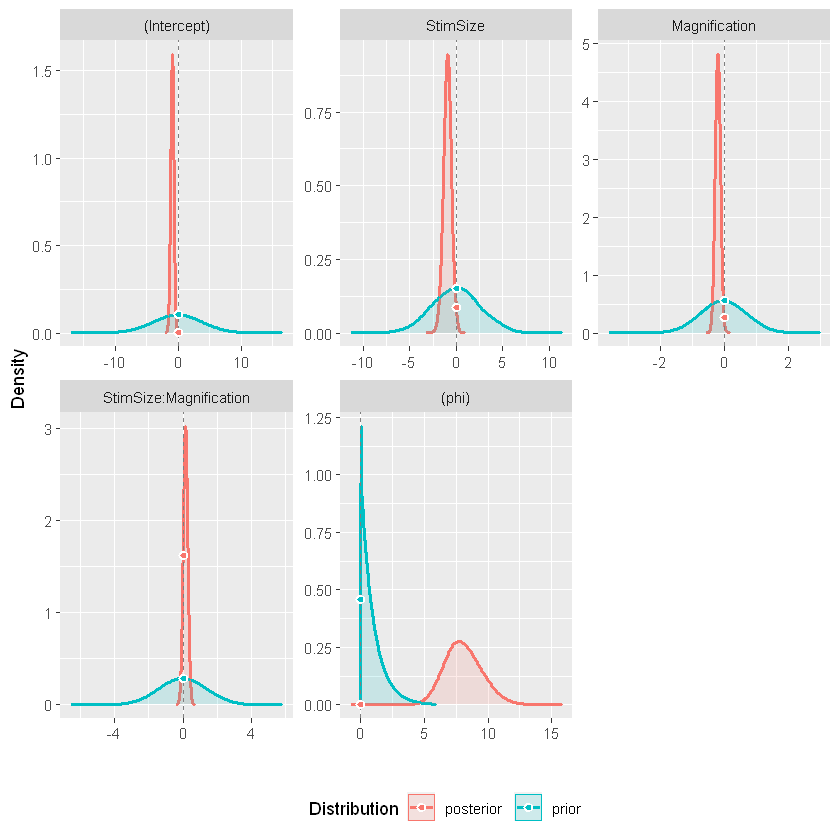

In [152]:
# test all the data
h2b(var.data)

# Additional Supplementary Figures

### Full dissimilarity plot for each participant per group

In [124]:
plot.all <- function(datadf,info=TRUE){
    size <- sort(unique(datadf$stimulus_radius))
    scale <- sort(unique(datadf$peripheral_scale))
    for(stim in (size)){
        for(mag in (scale)){
            data <- (subset(datadf,stimulus_radius == stim & peripheral_scale == mag))
            IDs <- sort(unique(data$subject))
            n <- length(IDs)
            group.label <- paste('Magnification',mag,'Size',stim)
            
            k=1
            plot.list <- list()
            for(id in IDs){
                #print(id) # testing
                subjectdf <- subset(data, subject == id)
                plot <- dissimplot.full(color.eccen.mat(dissimdata.subject(subjectdf),
                                                       symmeterise=FALSE,sym.CP=FALSE,),
                                        dependent='dissimilarity',label=id,
                                       info=info)
                plot.list[[k]] <- as.grob(plot)
                k = k+1
                #print(plot) # testing
             #   print(k) # testing
            }
            #print(plot.list) # testing
            g <- arrangeGrob(grobs = plot.list, ncol=4)
            #print(n) # testing
            #print(ceiling(n/3)*5) # testing
            ggsave(paste('supfig - Group -',group.label,'- all subjects.png'),g,height=ceiling(n/3)*5,width=22)
        }
    }
}

In [125]:
cleandf <- subset(datadf, noncompliant == 0)
cleandf <- subset(cleandf, (stimulus_radius == 1) | (stimulus_radius == 0.05))
#plot.all(cleandf)
plot.all(cleandf,info=FALSE)


# Sampling Plan

## Simulations

### Hypothesis 1

In [30]:
# helper functions
ab2mu <- function(a,b){
    return(a / (a + b))
}

ab2phi <- function(a,b){
    return(a + b)
}

muphi2a <- function(mu,phi){
    return(mu*phi)
}

muphi2b <- function(mu,phi){
    return(-mu*phi + phi)
}



In [31]:
# Generate beta distributions
gen_beta <- function(mu,phi,samples=20,plot=FALSE){
    a <- muphi2a(mu,phi)
    b <- muphi2b(mu,phi)
    rand.vals <- runif(samples)
    beta <- qbeta(rand.vals,a,b)
    if(plot){
        hist(beta, xlim = c(0,1))
    }
    return(beta)
}

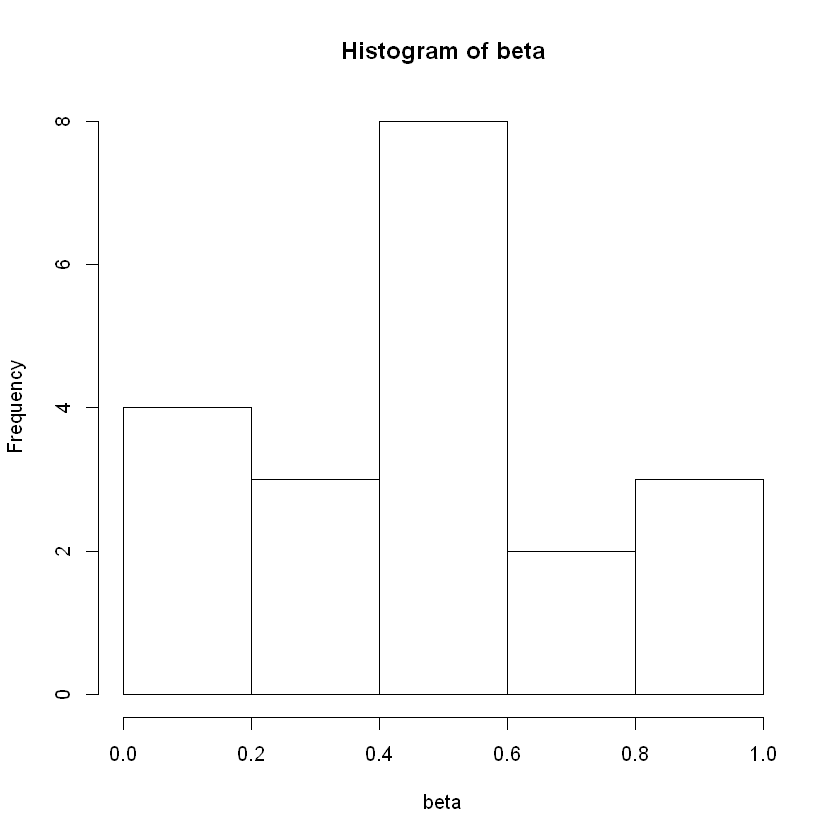

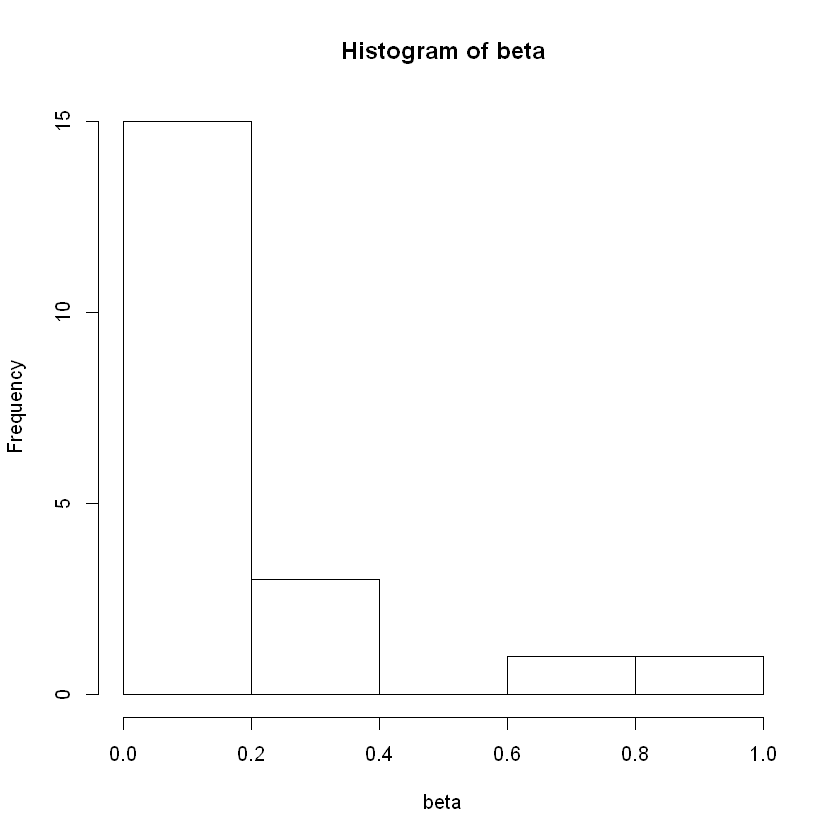

In [149]:
# Generate distributions for each potential group
fix0.05 <- gen_beta(0.5,2,plot=TRUE)
fix1 <- gen_beta(0.15,2,plot=TRUE)
mag0.05 <- gen_beta(0.15,2)
mag1 <- gen_beta(0.15,2)

# format the vectors
format.group <- function(value,name,stimsize,mag){
    df <- as.data.frame(value)
    df$name <- name
    df$StimSize <- stimsize
    df$Magnification <- mag
    df$ID <- c(1:nrow(df))
    
    return(df)
}


In [33]:
# put the samples in a dataframe
sim.df <- function(fix0.05,fix1,mag0.05,mag1){
    fix0.05df <- format.group(fix0.05,'FIX 0.05','small','fix')
    fix1df <- format.group(fix1,'FIX 1','big','fix')
    mag0.05df <- format.group(mag0.05,'MAG 0.05','small','mag')
    mag1df <- format.group(mag1,'MAG 1','big','mag')
    
    return(rbind(fix0.05df,fix1df,mag0.05df,mag1df))
}
sim.data <- sim.df(fix0.05,fix1,mag0.05,mag1)

In [34]:
# adjust samples so that the lowest values are equivalent to the experiment
sim.adjust <- function(df){
    df$value[df$value < (1/3)/max.DSR] <- 1/3/max.DSR
    return(df)
}
sim.data <- sim.adjust(sim.data)
head(sim.data)

value,name,StimSize,Magnification
0.74717487,FIX 0.05,small,fix
0.40390225,FIX 0.05,small,fix
0.04761905,FIX 0.05,small,fix
0.07798267,FIX 0.05,small,fix
0.55932544,FIX 0.05,small,fix
0.65112071,FIX 0.05,small,fix


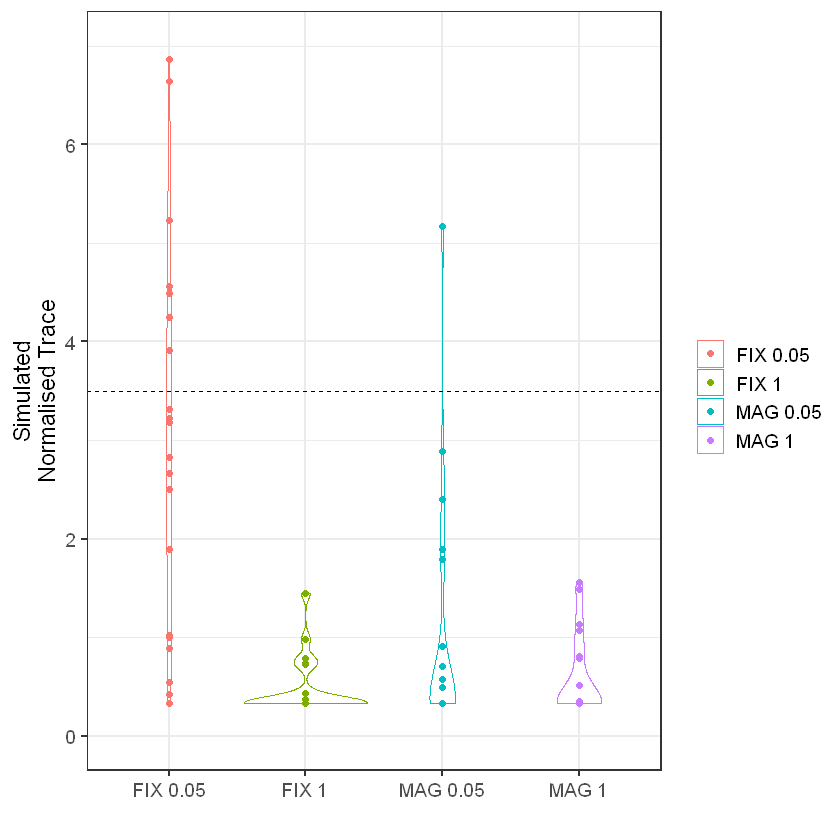

In [35]:
# plot the dataframe
plot.sim <- function(sim.data,histogram=FALSE,hyp=1){
    sim.data$value <- sim.data$value*max.DSR
    plot <- ggplot(sim.data, aes(x=name, y = value, color = name)) + 
            geom_violin() +
            geom_point(position=position_dodge(width=0.75)) +
            #scale_x_discrete(labels=c("FIX",'MAG')) +
            theme_bw(base_size = 14) +
            theme(legend.title=element_blank()) +
            xlab("")
            #scale_colour_manual(values = c("orange",'purple'))
    if(hyp==1){
        plot <- plot + ylim(0,7) +
        geom_hline(yintercept=3.5, linetype='dashed') +
        ylab("Simulated\nNormalised Trace") 
    } else if (hyp==2){
        plot <- plot + ylim(0,max(vals)) +
        geom_hline(yintercept=rand.var.mu, linetype='dashed') +
        ylab("Mean Variance") 
    }
    
    return(plot)
}
plot.sim(sim.data)

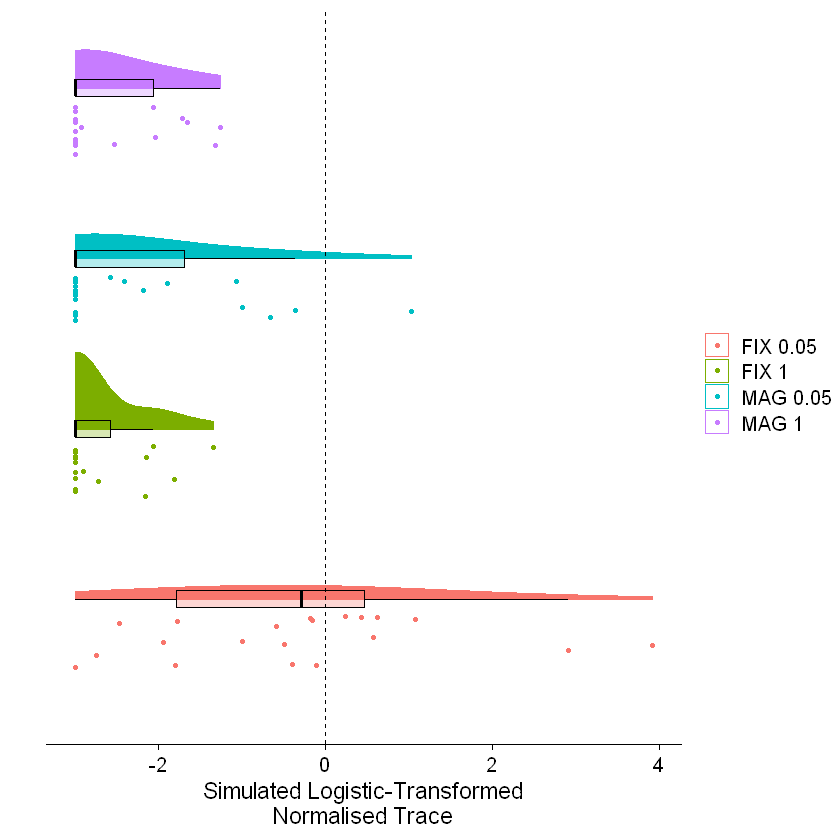

In [36]:
plot.sim.raincloud <- function(df){
    
    df$value <- logit(df$value)
    
    plot <- ggplot(df,aes(x=name,y=value,fill=name,colour=name)) +
            geom_flat_violin(position = position_nudge(x = 0.25, y = 0),adjust=2,trime=FALSE) +
            geom_point(position = position_jitter(width=.15,height=0),size=1) +
            geom_boxplot(aes(x=as.numeric(as.factor(name)) + 0.25, y = value),alpha = 0.3, outlier.shape=NA, width = .1, colour = "BLACK") +
            ylab("Simulated Logistic-Transformed\nNormalised Trace") + xlab('')+coord_flip()+theme_cowplot()+guides(fill=FALSE) +
            theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.line.y=element_blank(),legend.title=element_blank()) +
            geom_hline(yintercept=logit(0.5), linetype='dashed')
    
    return(plot)
}
plot.sim.raincloud(sim.data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.545 seconds (Warm-up)
Chain 1:                0.755 seconds (Sampling)
Chain 1:                1.3 seco

stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      value ~ StimSize + Magnification + StimSize:Magnification
 observations: 80
------
                               Median MAD_SD
(Intercept)                    -1.8    0.2  
StimSizesmall                   1.5    0.3  
Magnificationmag                0.0    0.3  
StimSizesmall:Magnificationmag -1.3    0.4  
(phi)                           4.4    0.7  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Sampling priors, please wait...
Loading required namespace: logspline


,Parameter,BF,Effects,Component
1,(Intercept),2.497642e+06,fixed,conditional
4,StimSizesmall,7.499373e+02,fixed,conditional
3,Magnificationmag,1.261951e-01,fixed,conditional
5,StimSizesmall:Magnificationmag,2.502353e+01,fixed,conditional
2,(phi),1.429166e+07,fixed,conditional


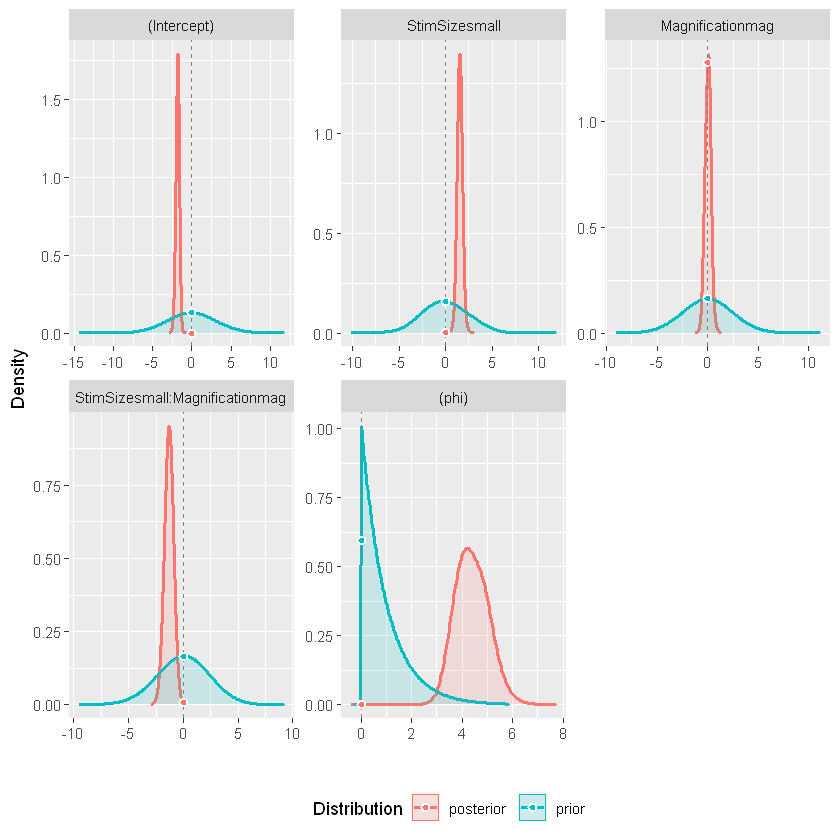

In [37]:
# Statistical test

sim.test <- stan_betareg(formula = value ~ StimSize + Magnification + StimSize:Magnification,
                        data = sim.data)
sim.test
region <- bayesfactor_parameters(sim.test)
region
plot(region, show_intercept = TRUE)

In [497]:
# put everything together
run.sim <- function(n=20,vis=0.1,blind=0.4,phi.vis=10,phi.blind=10,hyp=1,
                    seed.data=1,seed.test=1,seed.BF=3,
                   BF.samples=2,print1=FALSE,print2=FALSE,
                   within=TRUE){
    
    
    
    # Generate distributions for each potential group
    #set.seed(seed.data)
    
    
    #set.seed(seed.BF)
    BF.v <- vector()
    for(i in 1:BF.samples){
        
        fix0.05 <- gen_beta(blind,phi.blind, samples=n)
        fix1 <- gen_beta(vis,phi.vis, samples=n)
        mag0.05 <- gen_beta(vis,phi.vis, samples=n)
        mag1 <- gen_beta(vis,phi.vis, samples=n)

        sim.data <- sim.df(fix0.05,fix1,mag0.05,mag1)
        sim.data <- sim.adjust(sim.data)
        
        
        #set.seed(sample(1:10000, 1, replace=FALSE))
        if(within){
            sim.test <- stan_glmer(formula = value ~ Magnification + StimSize + StimSize:Magnification + (1|ID),
                        data = sim.data,
                            #prior_intercept=normal(mean(fix0.05),var(fix0.05)^0.5),
                            family = mgcv::betar,
                             refresh=0, # suppressed the output
                             iter=1000 # improve stability?
                            )
        } else {
            sim.test <- stan_betareg(formula = value ~ Magnification + StimSize + StimSize:Magnification,
                        data = sim.data,
                            #prior_intercept=normal(mean(fix0.05),var(fix0.05)^0.5),
                             refresh=0, # suppressed the output
                             iter=1000 # improve stability?
                            )
        }
        
        region <- bayesfactor_parameters(sim.test,
                                         #parameters='Magnificationmag:StimSizesmall',
                                        # direction='<'
                                        )
        BF.v[i] <- subset(region, Parameter == 'Magnificationmag:StimSizesmall')$BF
        if(print1){
            print(BF.v[i])
            print(plot.sim(sim.data,hyp=hyp))
        }
    }
    
    # show the stats test
    #set.seed(seed.test)
    if(print2){
        print(sim.test)
        print(region)
        print(plot(region, show_intercept = TRUE))
    }
    
    return(BF.v)
}

Sampling priors, please wait...


[1] 9.246035
stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      value ~ Magnification + StimSize + StimSize:Magnification
 observations: 20
------
                               Median MAD_SD
(Intercept)                    -2.0    0.4  
Magnificationmag                0.1    0.5  
StimSizesmall                   1.7    0.5  
Magnificationmag:StimSizesmall -2.0    0.7  
(phi)                           7.4    2.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg
Bayes Factor (Savage-Dickey density ratio)

Parameter                      |     BF
---------------------------------------
(Intercept)                    | 386.82
Magnificationmag               |  0.203
StimSizesmall                  |  18.23
Magnificationmag:StimSizesmall |   9.25
(phi)                          | > 1000

* Evidence Against The Null: 0

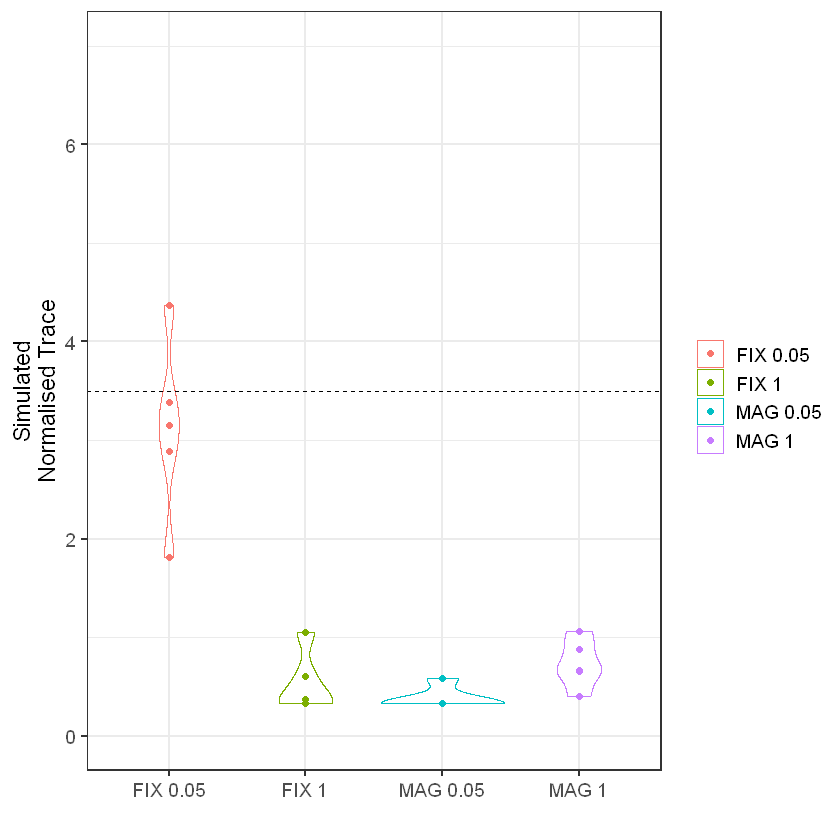

[1] 9.246035

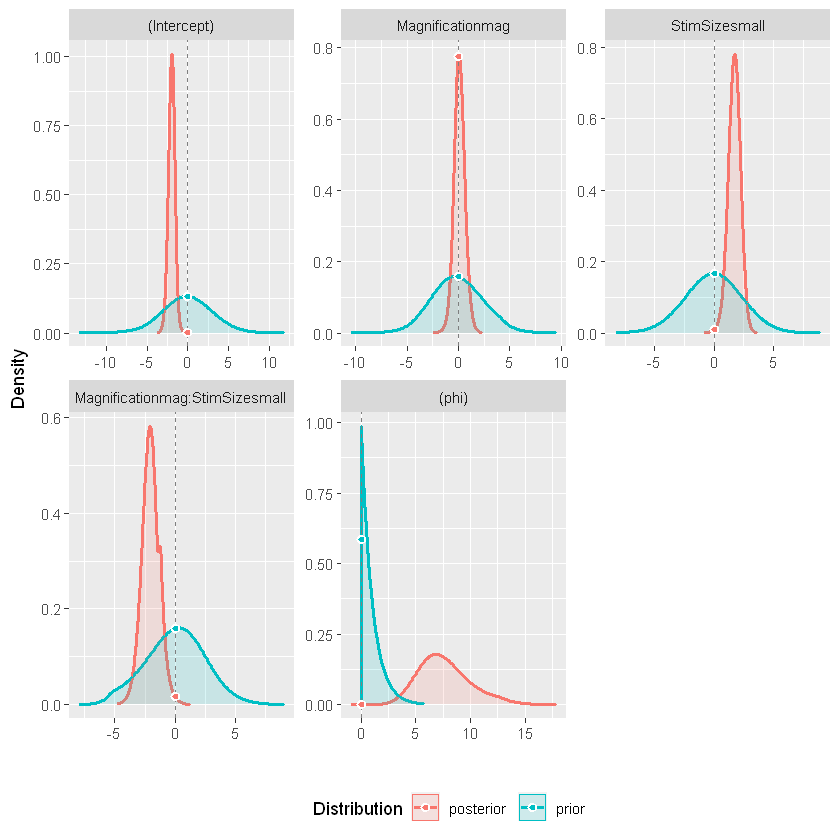

In [498]:
run.sim(n=5,vis=0.05,blind=0.32,phi.vis=10,phi.blind=10,
        seed.data=1,seed.test=9,seed.BF=26,BF.samples=1,
        print1=TRUE,print2=TRUE,
       within=FALSE)
#run.sim(n=20,vis=0.05,blind=0.32,phi.vis=2.2,phi.blind=2.2,seed.data=1,seed.test=9,seed.BF=26,BF.samples=5)

### Hypothesis 2

In [341]:
# visualise the distribution of possible variances
vis.var <- function(n=100000,log=FALSE){
    var.v <- vector()
    for(i in 1:n){
        entry <- sample(0:7, 3, replace=TRUE)
        var.v[i] <- var(entry)
    }
    print(mean(var.v))
    print(median(var.v))
    if(log){
        return(hist(log(var.v)))
    } else{
        return(hist(var.v,breaks=16, xlim=c(0,16)))
    }
    
}

[1] 5.279033
[1] 4.333333
[1] 5.26533
[1] 4.333333


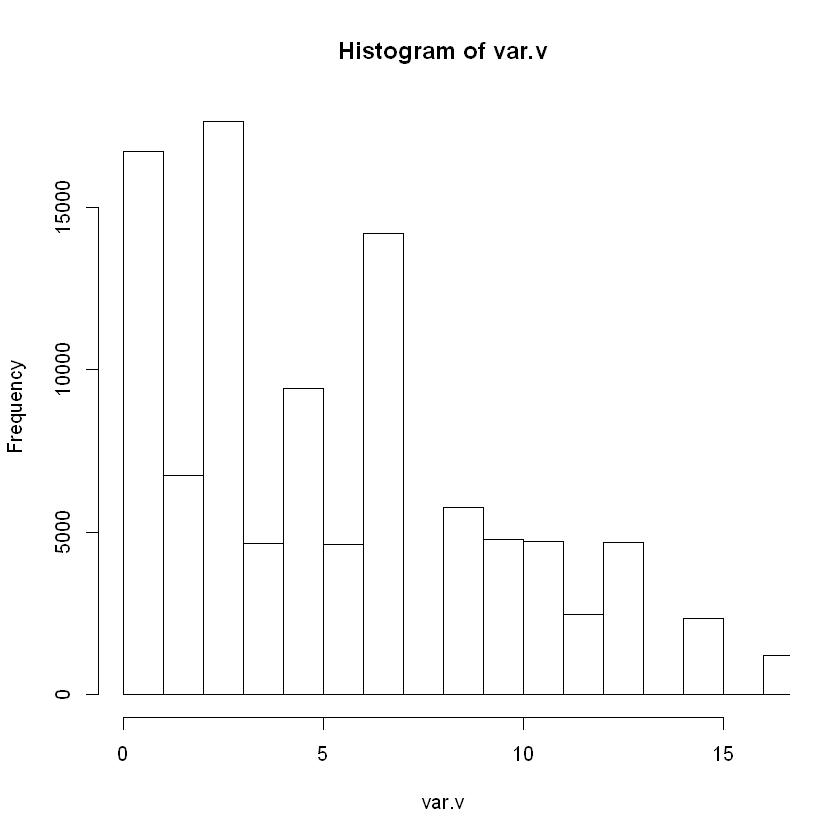

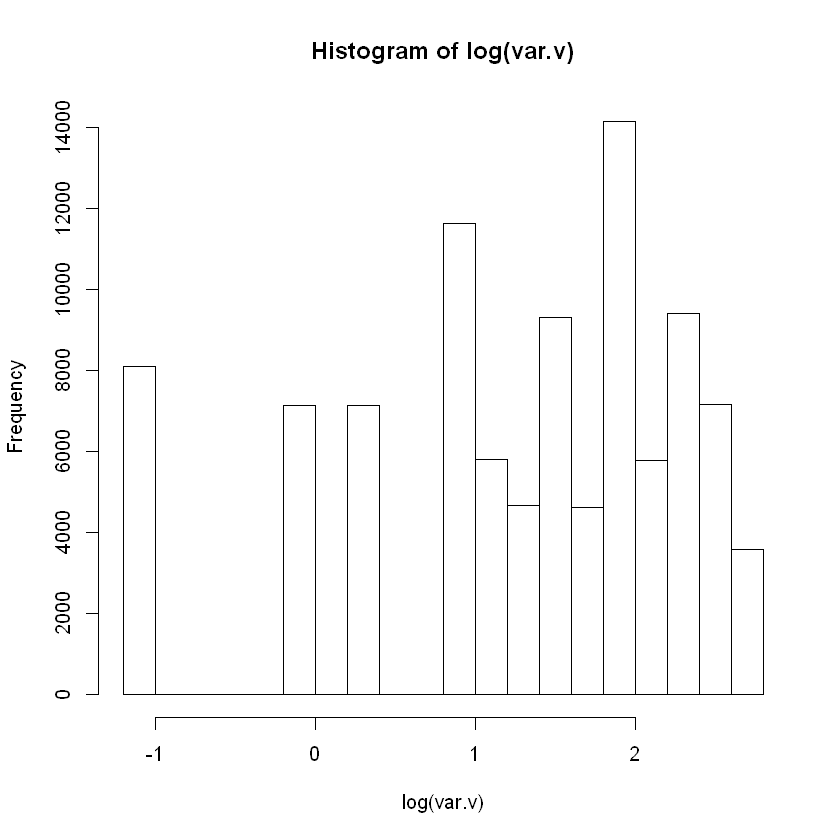

In [342]:
vis.var()
vis.var(log=TRUE)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.543 seconds (Warm-up)
Chain 1:                0.529 seconds (Sampling)
Chain 1:                1.072 seconds

Sampling priors, please wait...


Bayes Factor (Savage-Dickey density ratio)

Parameter                      |     BF
---------------------------------------
(Intercept)                    | > 1000
Magnificationmag               |  0.217
StimSizesmall                  | > 1000
Magnificationmag:StimSizesmall | 110.95
(phi)                          | > 1000

* Evidence Against The Null: 0

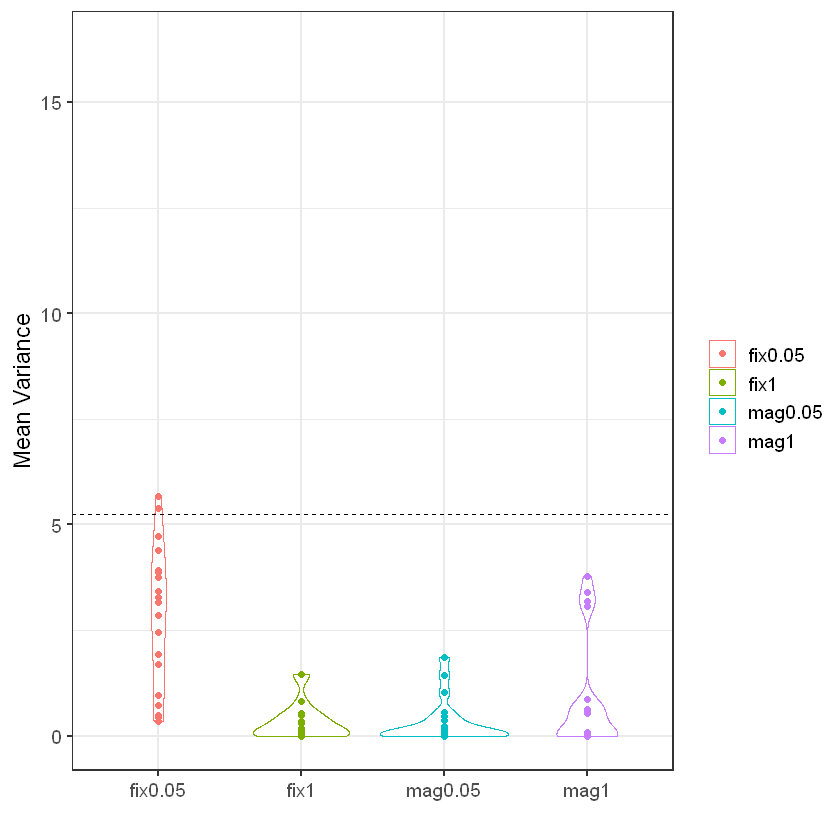

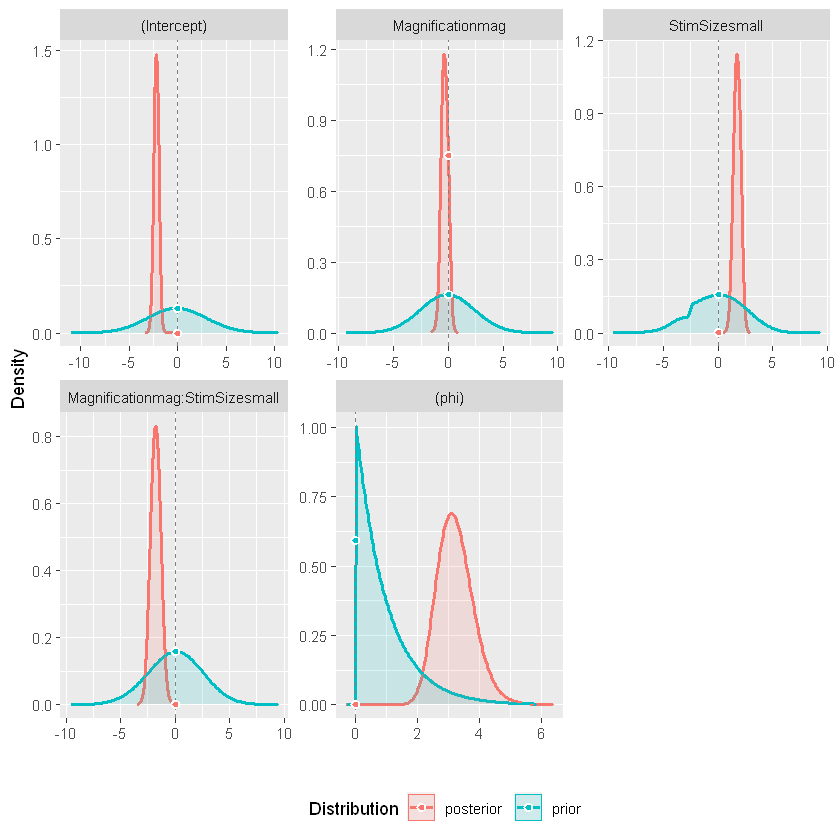

In [521]:
run.sim(n=20,vis=0.0625,blind=rand.var.mu/max(vals),phi.vis=5,phi.blind=5,hyp=2)

### Alternate analysis method

Going to explore what would happen if we instead worked on the transformations:  
 * CP' = CP - CC
 * PP' = PP - CC

$breaks
 [1] -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8

$counts
 [1]  145  350  470  605  839  925 1108 1241 1093  926  762  581  482  319  154

$density
 [1] 0.0145 0.0350 0.0470 0.0605 0.0839 0.0925 0.1108 0.1241 0.1093 0.0926
[11] 0.0762 0.0581 0.0482 0.0319 0.0154

$mids
 [1] -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5

$xname
[1] "v"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


[1] -6.5

[1] 7.5

[1] 0.4597

[1] 0.5

[1] 3.248374

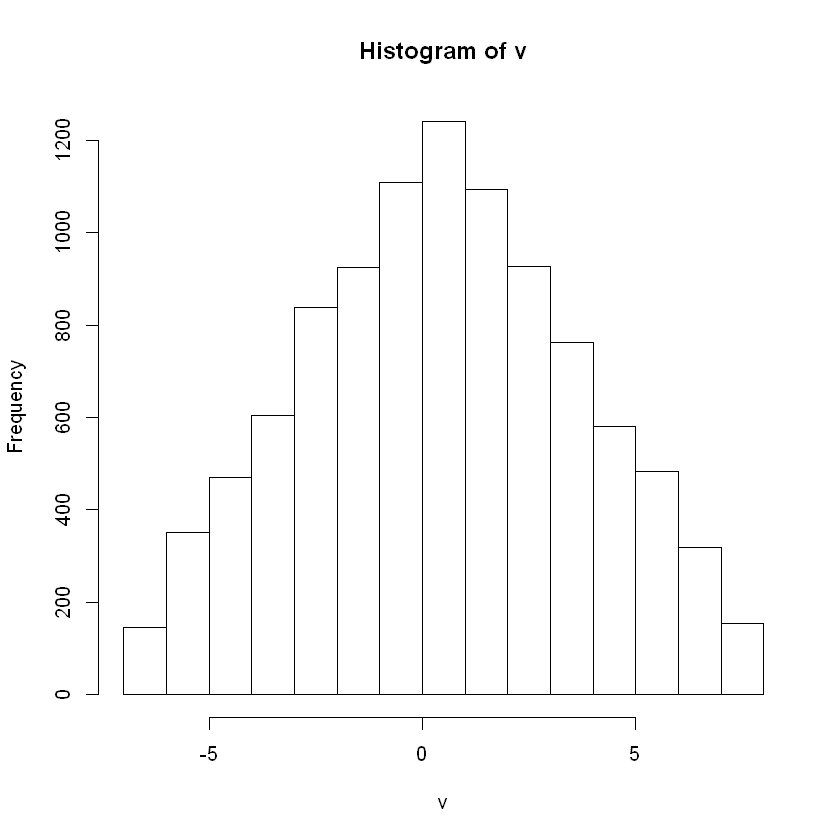

In [29]:
# calcualte the mean of the difference between two random dissimilarity values chosen n times
diff.trans <- function(n=10000,abs=TRUE){
    # possible dissimilarity values
    dis.v <- c(0:7)
    v <- vector()
    
    for(i in 1:n){
        d1 <- sample(dis.v, 1, replace=TRUE)
        d2 <- sample(dis.v, 1, replace=TRUE)
        if(abs){
            v[i] <- abs(d1 - d2)
            bins <- 8
        } else{
            v[i] <- (d1 - d2) + 0.5
            bins <- 15
        }
        
    }
    print(hist(v, breaks=bins, freq=TRUE))
    return(v)
}

dist <- diff.trans(abs=FALSE)
min(dist)
max(dist)
mean(dist)
median(dist)
sd(dist)
